# Playsense-id  model training

## 1.Basic analysis 

### 1.1  raw data 

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the data folder and file path
data_folder = "../data/"
data_file = "controller_data_user1_20250307_112616.csv"
file_path = os.path.join(data_folder, data_file)

# Check if the file exists before reading
if os.path.exists(file_path):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Display the first few rows of the DataFrame
    print("First 5 rows of the dataset:")
    display(df.head())
    
    # Count the values of the button_press column
    print("\nButton press counts:")
    display(df['button_press'].value_counts())
    
    # Display summary statistics
    print("\nSummary statistics:")
    display(df.describe())
    
    # Display information about the DataFrame
    print("\nDataFrame information:")
    df.info()
else:
    print(f"Error: File not found at {file_path}")
    print("Please check if the file exists or if the path is correct.")



First 5 rows of the dataset:


timestamp button_press  gyro_pitch  gyro_yaw  gyro_roll  \
0  2025-03-07T11:26:16.592564         none           0         0          0   
1  2025-03-07T11:26:16.597643         none        -491      8288      -1140   
2  2025-03-07T11:26:16.602667         none        -464      8259      -1143   
3  2025-03-07T11:26:16.606753         none        -449      8260      -1103   
4  2025-03-07T11:26:16.611815         none        -459      8284      -1092   

   acc_x  acc_y  acc_z user_id  
0      0      0      0   user1  
1    -55    -63     60   user1  
2    -46    -63     64   user1  
3    -36    -61     69   user1  
4    -27    -60     71   user1


Button press counts:


button_press
none      5605
up         139
left        78
right       62
down        59
square      52
cross       32
circle      24
Name: count, dtype: int64


Summary statistics:


gyro_pitch     gyro_yaw    gyro_roll        acc_x        acc_y  \
count  6051.000000  6051.000000  6051.000000  6051.000000  6051.000000   
mean   -236.425549  7955.655098 -1503.924475    27.447695    -5.453314   
std    1066.765135   359.150505  1111.600017   401.740601   325.274700   
min   -2716.000000     0.000000 -4226.000000 -1731.000000 -2019.000000   
25%    -776.000000  7897.000000 -2084.500000   -25.000000   -14.000000   
50%    -590.000000  7994.000000 -1911.000000     2.000000     5.000000   
75%    -179.000000  8147.000000  -986.000000    35.000000    30.000000   
max    3919.000000  9395.000000  3920.000000  2089.000000  1272.000000   

             acc_z  
count  6051.000000  
mean     36.862502  
std     395.302357  
min   -2308.000000  
25%     -17.000000  
50%       9.000000  
75%      45.000000  
max    2163.000000


DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6051 entries, 0 to 6050
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     6051 non-null   object
 1   button_press  6051 non-null   object
 2   gyro_pitch    6051 non-null   int64 
 3   gyro_yaw      6051 non-null   int64 
 4   gyro_roll     6051 non-null   int64 
 5   acc_x         6051 non-null   int64 
 6   acc_y         6051 non-null   int64 
 7   acc_z         6051 non-null   int64 
 8   user_id       6051 non-null   object
dtypes: int64(6), object(3)
memory usage: 425.6+ KB


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib.ticker import MaxNLocator


# ========= functions for the anlaysis the raw df =====================
def preprocess_data(df):
    """Preprocess the input DataFrame."""
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df_analysis = df.copy()
    return df_analysis

def extract_button_events(df_analysis):
    """Extract relevant button events and transitions."""
    button_events = df_analysis[~df_analysis['button_press'].str.contains('EVENT:', na=False)].copy()
    button_events['prev_button'] = button_events['button_press'].shift(1)
    button_events['is_transition'] = button_events['button_press'] != button_events['prev_button']
    button_events['press_start'] = (button_events['prev_button'] == 'none') & (button_events['button_press'] != 'none')
    button_events['press_end'] = (button_events['prev_button'] != 'none') & (button_events['button_press'] == 'none')
    return button_events

def detect_buttons(button_events):
    """Detect all unique buttons in the dataset."""
    all_buttons = set()
    for buttons in button_events['button_press'].unique():
        if isinstance(buttons, str) and buttons != 'none' and not buttons.startswith('EVENT:'):
            all_buttons.update(buttons.split(','))
    return all_buttons

def compute_button_statistics(button_events, all_buttons):
    """Compute statistics for each button."""
    press_starts = button_events[button_events['press_start']].copy()
    button_stats = {}
    for button in all_buttons:
        count = sum(press_starts['button_press'].str.contains(button, na=False))
        button_presses = button_events[button_events['button_press'].str.contains(button, na=False)].copy()
        if not button_presses.empty:
            button_presses.loc[:, 'group'] = button_presses['is_transition'].cumsum()
            grouped = button_presses.groupby('group')
            avg_sequence = grouped.size().mean()
            last_press = button_presses['timestamp'].max()
            sequences = [(group['timestamp'].max() - group['timestamp'].min()).total_seconds() * 1000 
                         for _, group in grouped if len(group) > 1]
            avg_duration = np.mean(sequences) if sequences else np.nan
            button_stats[button] = {
                'count': count,
                'avg_sequence_length': avg_sequence,
                'avg_duration_ms': avg_duration,
                'last_press': last_press
            }
    return pd.DataFrame.from_dict(button_stats, orient='index').reset_index().rename(columns={'index': 'button'}).sort_values('count', ascending=False)

def plot_button_statistics(stats_df, button_events, all_buttons):
    """Generate visualizations of button statistics."""
    plt.figure(figsize=(14, 10))
    
    # Create data for boxplots
    button_records = {}
    button_durations = {}
    
    for button in all_buttons:
        button_presses = button_events[button_events['button_press'].str.contains(button, na=False)].copy()
        if not button_presses.empty:
            button_presses.loc[:, 'group'] = button_presses['is_transition'].cumsum()
            grouped = button_presses.groupby('group')
            
            # Collect records count for each press event
            records_counts = grouped.size().values
            button_records[button] = records_counts
            
            # Collect duration for each press event
            durations = [(group['timestamp'].max() - group['timestamp'].min()).total_seconds() * 1000 
                         for _, group in grouped if len(group) > 1]
            if durations:
                button_durations[button] = durations
    
    # Plot records count boxplot
    plt.subplot(2, 2, 1)
    plt.boxplot([button_records[button] for button in all_buttons], tick_labels=all_buttons)
    plt.title('Distribution of Records Count per Button Press')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45)
    
    # Plot duration boxplot
    plt.subplot(2, 2, 2)
    valid_buttons = [button for button in all_buttons if button in button_durations and button_durations[button]]
    if valid_buttons:
        plt.boxplot([button_durations[button] for button in valid_buttons], tick_labels=valid_buttons)
        plt.title('Distribution of Press Duration per Button')
        plt.ylabel('Duration (ms)')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'No valid duration data available', ha='center', va='center')
    
    # Plot sequence events timeline
    plt.subplot(2, 1, 2)
    press_events = button_events[button_events['button_press'] != 'none'].copy()
    if not press_events.empty:
        # Get the time range
        min_time = press_events['timestamp'].min()
        max_time = press_events['timestamp'].max()
        
        # Create a dictionary to store button positions on y-axis
        button_positions = {button: i for i, button in enumerate(all_buttons)}
        
        # Plot each button press as a vertical line
        for button in all_buttons:
            button_data = press_events[press_events['button_press'].str.contains(button, na=False)]
            if not button_data.empty:
                # Convert timestamps to seconds from start
                times = [(t - min_time).total_seconds() for t in button_data['timestamp']]
                # Plot vertical lines for each press
                for t in times:
                    plt.plot([t, t], [button_positions[button]-0.2, button_positions[button]+0.2], 'k-', linewidth=1.5)
        
        plt.yticks(list(button_positions.values()), list(button_positions.keys()))
        plt.xlabel('Time (seconds from start)')
        plt.title('Button Press Events Timeline')
        plt.xlim(0, (max_time - min_time).total_seconds())
    else:
        plt.text(0.5, 0.5, 'No button press events available', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

def analyze_button_sequences(button_events):
    """Analyze temporal patterns between button presses. For example A->B , B->C as pattern"""
    sequences = button_events[button_events['button_press'] != 'none'].copy()
    sequences.loc[:, 'time_diff'] = (sequences['timestamp'] - sequences['timestamp'].shift(1)).dt.total_seconds() * 1000
    sequences = sequences[~sequences['prev_button'].isna()]
    common_sequences = []
    for i in range(len(sequences) - 1):
        if sequences.iloc[i]['is_transition'] and sequences.iloc[i+1]['is_transition']:
            btn1, btn2 = sequences.iloc[i]['button_press'], sequences.iloc[i+1]['button_press']
            time_diff = sequences.iloc[i+1]['time_diff']
            if not pd.isna(time_diff) and btn1 != 'none' and btn2 != 'none':
                common_sequences.append((btn1, btn2, time_diff))
    if common_sequences:
        seq_df = pd.DataFrame(common_sequences, columns=['first_button', 'second_button', 'time_diff_ms'])
        sequence_counts = seq_df.groupby(['first_button', 'second_button']).size().reset_index(name='count').sort_values('count', ascending=False).head(10)
        timing_stats = seq_df.groupby(['first_button', 'second_button'])['time_diff_ms'].agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('mean')
        return sequence_counts, timing_stats
    return None, None


def find_button_press_intervals(df_analysis):
    """Finds all press and non-press intervals in button press data."""

    # Ensure data is sorted by timestamp
    df_analysis = df_analysis.sort_values(by='timestamp').reset_index(drop=True)

    # Compute time difference between consecutive rows in milliseconds
    df_analysis['time_diff'] = df_analysis['timestamp'].diff().dt.total_seconds() * 1000  # ms

    # Create group identifiers for sequences of same type (press or none)
    df_analysis['group'] = (df_analysis['button_press'] != df_analysis['button_press'].shift()).cumsum()

    # Group sequences and calculate duration
    grouped = df_analysis.groupby('group').agg(
        press_type=('button_press', 'first'),
        start_time=('timestamp', 'first'),
        end_time=('timestamp', 'last')
    )

    grouped['duration'] = (grouped['end_time'] - grouped['start_time']).dt.total_seconds() * 1000  # ms

    # Extracting press and non-press intervals
    non_press_intervals= grouped[grouped['press_type'] != 'none']['duration'] # not none means the press duration, non-press interval
    press_intervals = grouped[grouped['press_type'] == 'none']['duration'] # none means the press interval, non-press duration 

    # Plotting the distributions
    plt.figure(figsize=(14, 10))

    # Plot press intervals
    plt.subplot(2, 2, 1)
    sns.histplot(press_intervals, kde=True, color='blue', bins=30)
    plt.title('Distribution of Button Press Intervals')
    plt.xlabel('Time Interval (ms)')
    plt.ylabel('Frequency')

    # Plot non-press intervals
    plt.subplot(2, 2, 2)
    sns.histplot(non_press_intervals, kde=True, color='red', bins=30)
    plt.title('Distribution of Non-Press Intervals/Button press duration')
    plt.xlabel('Time Interval (ms)')
    plt.ylabel('Frequency')

    # Plot non-press sequence lengths (number of consecutive "none")
    plt.subplot(2, 2, 3)
    non_press_lengths = (df_analysis['button_press'] == 'none').astype(int).groupby(df_analysis['group']).sum()
    non_press_lengths = non_press_lengths[non_press_lengths > 0]  # Remove zeros

    if not non_press_lengths.empty:
        ax = sns.histplot(non_press_lengths, kde=True, color='green', bins=30)
        plt.title('Distribution of Non-Press Sequence Lengths')
        plt.xlabel('Number of Consecutive Non-Press Records')
        plt.ylabel('Frequency')

        # Add labels to bars
        for p in ax.patches:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            if y > 0.5:  # Only label bars with height > 0.5
                ax.annotate(f'{int(x)}', (x, y), ha='center', va='bottom', fontsize=8)
    else:
        plt.text(0.5, 0.5, 'No non-press sequences found', horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

    return press_intervals, non_press_intervals

# ==============functions for the raws ====================



# main function call to anlysis the df data to know the infor of the press button events 
def analyze_button_presses_with_intervals(df):
    """Function to execute button press analysis along with interval analysis."""
    df_analysis = preprocess_data(df)
    button_events = extract_button_events(df_analysis)
    all_buttons = detect_buttons(button_events)
    print(f"Detected buttons: {', '.join(sorted(all_buttons))}")
    
    # Compute statistics and visualize button press events
    stats_df = compute_button_statistics(button_events, all_buttons)
    display(stats_df)
    plot_button_statistics(stats_df, button_events, all_buttons)
    
    # Analyze and visualize button press and non-press intervals
    press_intervals, non_press_intervals = find_button_press_intervals(df_analysis)

    # Optional: Print interval statistics (mean, std, etc.)
    print(f"\nPress Intervals: Mean = {press_intervals.mean():.2f} ms, Std = {press_intervals.std():.2f} ms")
    print(f"Non-Press Intervals: Mean = {non_press_intervals.mean():.2f} ms, Std = {non_press_intervals.std():.2f} ms")
    
    # Analyze button sequences
    sequence_counts, timing_stats = analyze_button_sequences(button_events)
    if sequence_counts is not None:
        print("\nTop 10 Most Common Button Sequences:")
        display(sequence_counts)
        print("\nTiming Between Button Sequences (ms):")
        display(timing_stats)
    else:
        print("No button sequences detected in the data.")
    
    if not stats_df.empty:
        most_pressed = stats_df.iloc[0]
        print(f"\nMost pressed button: {most_pressed['button']} ({most_pressed['count']} times)")
        valid_durations = stats_df.dropna(subset=['avg_duration_ms'])
        if not valid_durations.empty:
            longest_press = valid_durations.iloc[valid_durations['avg_duration_ms'].idxmax()]
            print(f"Button with longest average press: {longest_press['button']} ({longest_press['avg_duration_ms']:.2f} ms)")

Detected buttons: circle, cross, down, left, right, square, up


button  count  avg_sequence_length  avg_duration_ms  \
4      up      4                34.75          168.396   
1   right      2                31.00          149.826   
0  square      2                26.00          124.262   
6    down      2                29.50          141.712   
5    left      2                39.00          188.871   
2   cross      1                32.00          155.041   
3  circle      1                24.00          114.504   

                  last_press  
4 2025-03-07 11:26:43.644303  
1 2025-03-07 11:26:43.127398  
0 2025-03-07 11:26:39.552093  
6 2025-03-07 11:26:42.421261  
5 2025-03-07 11:26:41.847694  
2 2025-03-07 11:26:39.999734  
3 2025-03-07 11:26:40.497528

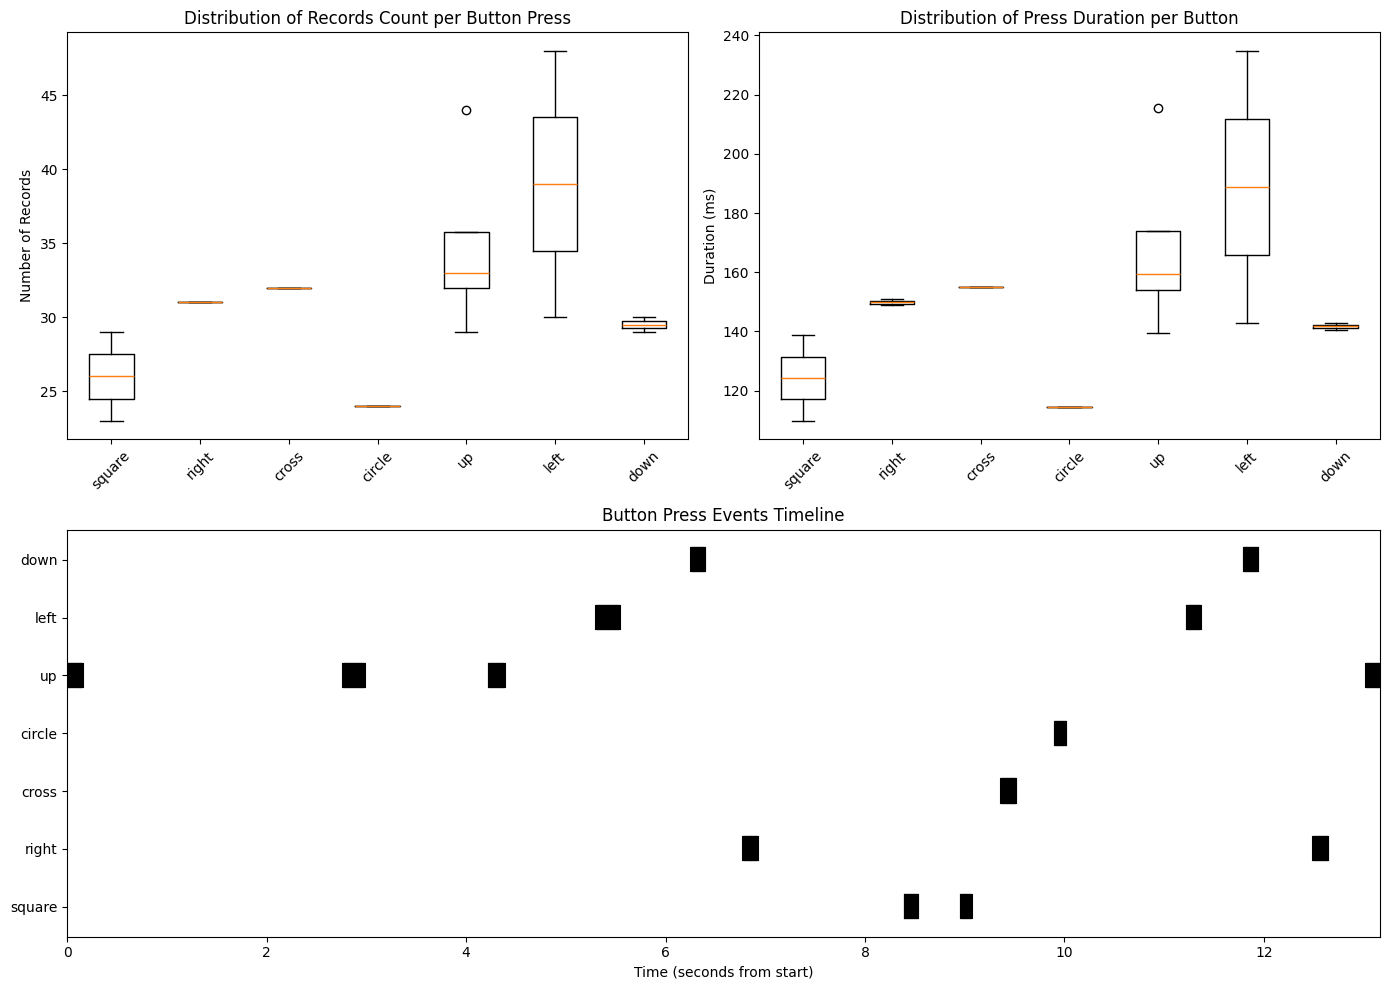

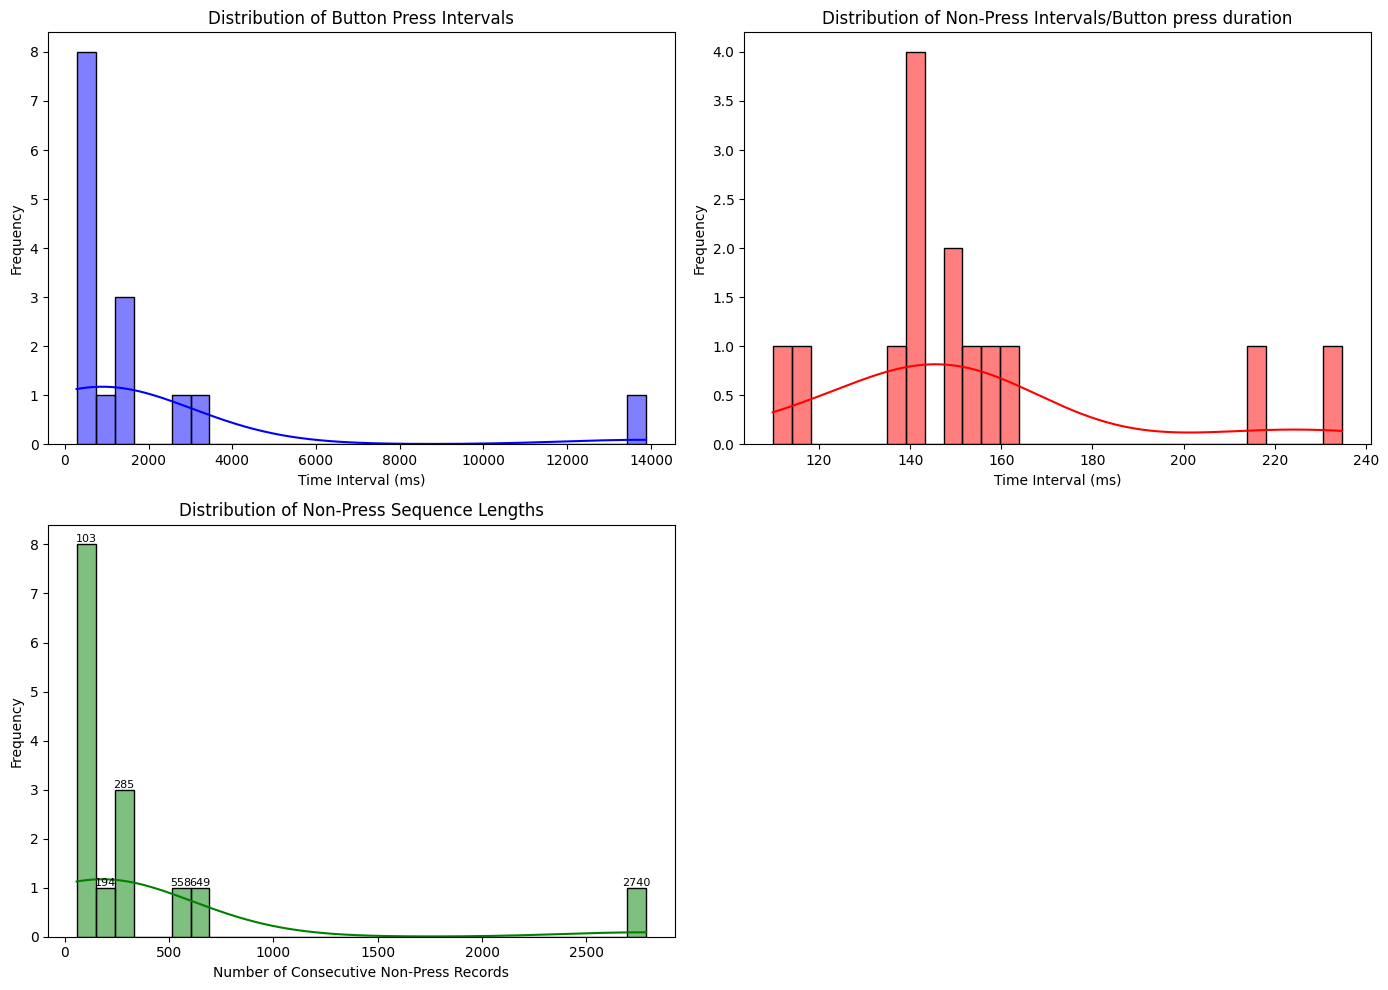


Press Intervals: Mean = 1858.36 ms, Std = 3432.21 ms
Non-Press Intervals: Mean = 153.75 ms, Std = 33.71 ms
No button sequences detected in the data.

Most pressed button: up (4 times)
Button with longest average press: cross (155.04 ms)


In [28]:
analyze_button_presses_with_intervals(df=df)

The interval between the button press and non-press will define the prepare data length

### 1.2 Extract method 

- 100 records: 50 before press, 50 after press
- reog to new dataframe

In [5]:
def extract_press_events(csv_file, output_file):
    """
    Extract button press events from a CSV file and save them as a new dataset.
    Each event contains 100 records: 50 before the first button press and 50 after.
    Each event is assigned a group_index to identify which segment it belongs to.
    
    Parameters:
    csv_file (str): Path to the input CSV file.
    output_file (str): Path to save the output CSV file.
    """
    # Load data
    df = pd.read_csv(csv_file)
    
    # Ensure timestamp is datetime if present
    if 'timestamp' in df.columns and df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Identify indices where button press starts (first occurrence of a non-'none' value after 'none')
    press_indices = df.index[df['button_press'].shift(1, fill_value='none') == 'none']
    press_indices = press_indices[df.loc[press_indices, 'button_press'] != 'none']
    
    # Extract events (50 records before and 50 after each detected press) 100 is too long may acuse the overlap
    event_segments = []
    for group_idx, idx in enumerate(press_indices):
        start_idx = max(0, idx - 50)  # Ensure index does not go below 0
        end_idx = min(len(df), idx + 50)  # Ensure index does not exceed dataset length
        segment = df.iloc[start_idx:end_idx].copy()
        segment['group_index'] = group_idx  # Add group_index to identify the segment
        event_segments.append(segment)
    
    # Concatenate all event segments into a new DataFrame
    extracted_data = pd.concat(event_segments).reset_index(drop=True)
    
    # Save extracted data to a new CSV file
    extracted_data.to_csv(output_file, index=False)
    print(f"Extracted data saved to {output_file}")


# 100 + 100 is too long for the quick change of the button pressing, cause the overlap in the data 

In [12]:
# Rename the output as xxx.csv to xxx_pro.csv
# 
import os 

file_name = os.path.basename(file_path)
file_base, file_ext = os.path.splitext(file_name)
file_out = os.path.join(os.path.dirname(file_path), f"{file_base}_pro{file_ext}")



Processed data shape: (1400, 9)

First few rows of processed data:


timestamp button_press  gyro_pitch  gyro_yaw  gyro_roll  \
0  2025-03-07 11:26:30.229072         none       -1033      7907      -2113   
1  2025-03-07 11:26:30.234104         none       -1055      7870      -2135   
2  2025-03-07 11:26:30.239138         none       -1068      7897      -2141   
3  2025-03-07 11:26:30.244168         none       -1102      7854      -2144   
4  2025-03-07 11:26:30.249582         none       -1032      7844      -2143   

   acc_x  acc_y  acc_z user_id  
0     36    -15     19   user1  
1     34    -15     22   user1  
2     24    -13     24   user1  
3     17    -10     26   user1  
4     -4     -2     34   user1


Button press events in processed data:


button_press
up        139
left       78
right      62
down       59
square     52
cross      32
circle     24
Name: count, dtype: int64

Detected buttons: circle, cross, down, left, right, square, up


button  count  avg_sequence_length  avg_duration_ms  \
4      up      4                34.75          168.396   
1   right      2                31.00          149.826   
0  square      2                26.00          124.262   
6    down      2                29.50          141.712   
5    left      2                39.00          188.871   
2   cross      1                32.00          155.041   
3  circle      1                24.00          114.504   

                  last_press  
4 2025-03-07 11:26:43.644303  
1 2025-03-07 11:26:43.127398  
0 2025-03-07 11:26:39.552093  
6 2025-03-07 11:26:42.421261  
5 2025-03-07 11:26:41.847694  
2 2025-03-07 11:26:39.999734  
3 2025-03-07 11:26:40.497528

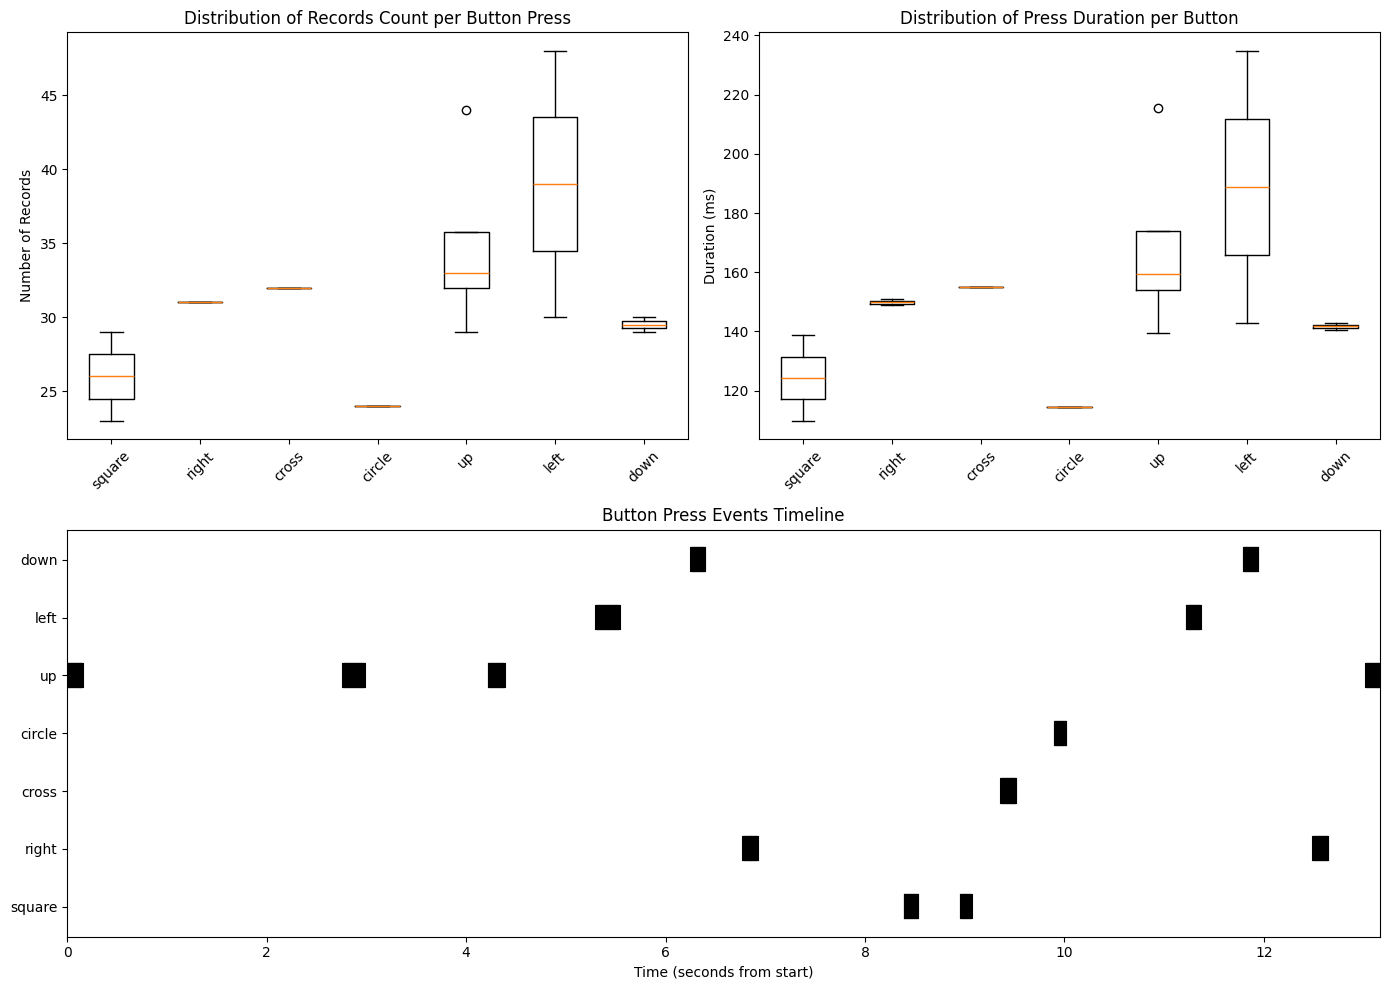

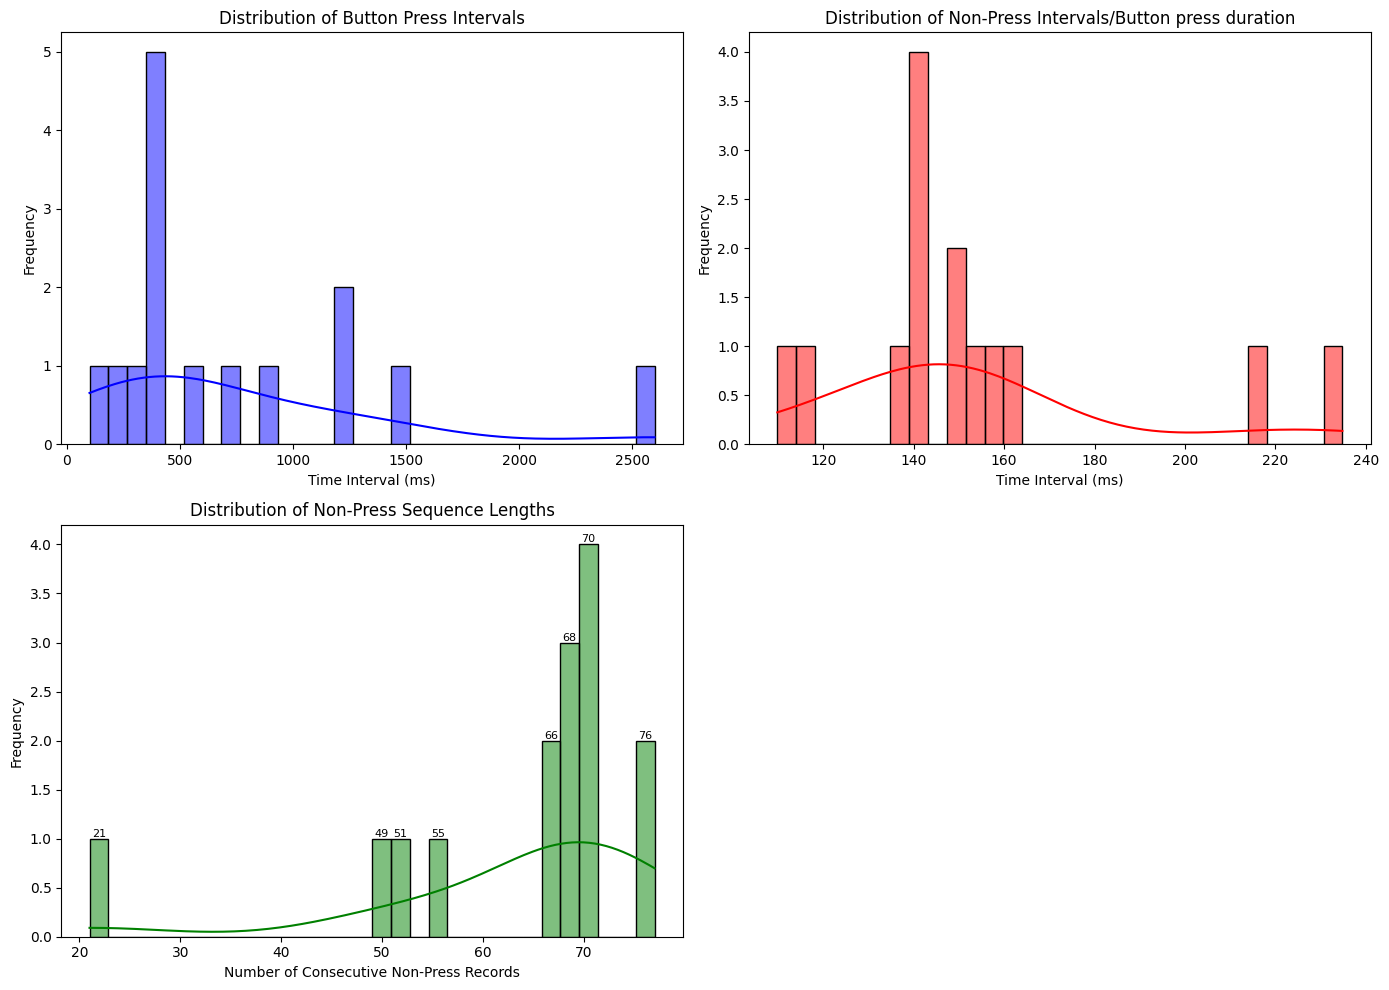


Press Intervals: Mean = 748.45 ms, Std = 653.06 ms
Non-Press Intervals: Mean = 153.75 ms, Std = 33.71 ms
No button sequences detected in the data.

Most pressed button: up (4 times)
Button with longest average press: cross (155.04 ms)


In [31]:
# compare the extra or post-extra

# read the file_out into the df_post
df_post = pd.read_csv(file_out)

# Display basic information about the processed data
print(f"Processed data shape: {df_post.shape}")
print("\nFirst few rows of processed data:")
display(df_post.head())

# Count button press events by type
button_counts = df_post[df_post['button_press'] != 'none']['button_press'].value_counts()
print("\nButton press events in processed data:")
display(button_counts)


analyze_button_presses_with_intervals(df=df_post)


In [7]:
import os
import pandas as pd
folder_path = "../data/"
user2_csv="controller_data_user1_20250310_100504_u2.csv"
user3_csv="controller_data_user1_20250310_100733_u3.csv"
user4_csv="controller_data_user1_20250310_101102_u4.csv"

extract_press_events(folder_path+user2_csv,folder_path+"controller_data_user1_20250310_100504_u2_pro.csv")
extract_press_events(folder_path+user3_csv,folder_path+"controller_data_user1_20250310_100733_u3_pro.csv")
extract_press_events(folder_path+user4_csv,folder_path+"controller_data_user1_20250310_101102_u4_pro.csv")





Extracted data saved to ../data/controller_data_user1_20250310_100504_u2_pro.csv
Extracted data saved to ../data/controller_data_user1_20250310_100733_u3_pro.csv
Extracted data saved to ../data/controller_data_user1_20250310_101102_u4_pro.csv


### 1.3 Visualize data

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_event_durations(csv_file):
    """
    Plot two visualizations:
    1. Sequence of events (none/press/none) in each group showing time relation
    2. Time span (duration) of each group broken down by event types (none/press/none)
    
    Parameters:
    csv_file (str): Path to the extracted CSV file.
    """
    # Load the extracted dataset
    df = pd.read_csv(csv_file)
    
    # Ensure timestamp is datetime if present
    if 'timestamp' in df.columns and df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Group by group_index and calculate counts and durations
    group_data = []
    time_span_data = []
    
    for group_idx, group_df in df.groupby('group_index'):
        # Calculate time span of the group
        if 'timestamp' in group_df.columns:
            time_span = (group_df['timestamp'].max() - group_df['timestamp'].min()).total_seconds() * 1000  # in milliseconds
        else:
            time_span = len(group_df)  # If no timestamp, use record count
        
        # Analyze the sequence pattern (none-press-none)
        events = group_df['button_press'].tolist()
        
        # Find the first non-none event index
        first_press_idx = next((i for i, e in enumerate(events) if e != 'none'), None)
        
        # Find the last non-none event index
        last_press_idx = next((len(events) - 1 - i for i, e in enumerate(reversed(events)) if e != 'none'), None)
        
        # Calculate the counts for each segment
        pre_none_count = first_press_idx if first_press_idx is not None else 0
        press_count = group_df[group_df['button_press'] != 'none'].shape[0]
        post_none_count = len(events) - last_press_idx - 1 if last_press_idx is not None else 0
        
        group_data.append({
            'group_index': group_idx, 
            'pre_none_count': pre_none_count,
            'press_count': press_count, 
            'post_none_count': post_none_count,
            'total_count': len(events)
        })
        
        # Calculate time spans for each segment
        if 'timestamp' in group_df.columns:
            sorted_group = group_df.sort_values('timestamp')
            timestamps = sorted_group['timestamp'].tolist()
            
            # Calculate time spans in milliseconds
            pre_none_time = 0
            press_time = 0
            post_none_time = 0
            
            if first_press_idx is not None and first_press_idx > 0:
                pre_none_time = (timestamps[first_press_idx] - timestamps[0]).total_seconds() * 1000
            
            if first_press_idx is not None and last_press_idx is not None:
                press_time = (timestamps[last_press_idx] - timestamps[first_press_idx]).total_seconds() * 1000
            
            if last_press_idx is not None and last_press_idx < len(timestamps) - 1:
                post_none_time = (timestamps[-1] - timestamps[last_press_idx]).total_seconds() * 1000
            
            time_span_data.append({
                'group_index': group_idx,
                'pre_none_time': pre_none_time,
                'press_time': press_time,
                'post_none_time': post_none_time,
                'total_time': time_span
            })
        else:
            # If no timestamp, use record counts as proxy for time
            time_span_data.append({
                'group_index': group_idx,
                'pre_none_time': pre_none_count,
                'press_time': press_count,
                'post_none_time': post_none_count,
                'total_time': len(events)
            })
    
    # Convert to DataFrames
    group_df = pd.DataFrame(group_data)
    time_span_df = pd.DataFrame(time_span_data)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot 1: Stacked bar chart showing the time relation (none-press-none) per group
    group_df.plot(
        x='group_index', 
        y=['pre_none_count', 'press_count', 'post_none_count'],
        kind='bar',
        stacked=True,
        ax=ax1,
        color=['#1f77b4', '#ff7f0e', '#2ca02c'],
        legend=True
    )
    ax1.set_xlabel("Group Index")
    ax1.set_ylabel("Count")
    ax1.set_title("Event Sequence Pattern per Group")
    ax1.legend(["Pre-Press (none)", "Press Events", "Post-Press (none)"])
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, linestyle="--", alpha=0.5)
    
    # Plot 2: Stacked bar chart showing time spans broken down by event types
    time_span_df.plot(
        x='group_index', 
        y=['pre_none_time', 'press_time', 'post_none_time'],
        kind='bar',
        stacked=True,
        ax=ax2,
        color=['#1f77b4', '#ff7f0e', '#2ca02c'],
        legend=True
    )
    ax2.set_xlabel("Group Index")
    ax2.set_ylabel("Time Span (milliseconds)")
    ax2.set_title("Time Span of Each Group by Event Type")
    ax2.legend(["Pre-Press (none)", "Press Events", "Post-Press (none)"])
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, linestyle="--", alpha=0.5)
    
    plt.tight_layout()
    plt.show()


In [38]:
user2_pro_csv="controller_data_user2_20250310_100504_pro_filtered.csv"
user3_pro_csv="controller_data_user3_20250310_100733_pro_filtered.csv"
user4_pro_csv="controller_data_user4_20250310_101102_pro_filtered.csv"


### 1.4 Data preparation 







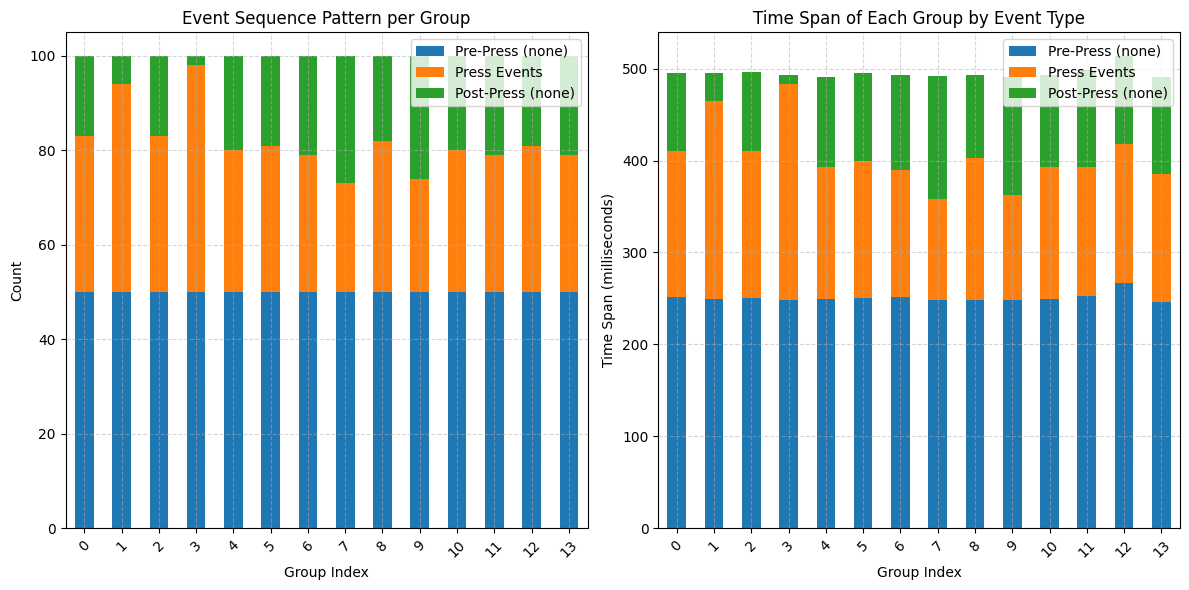

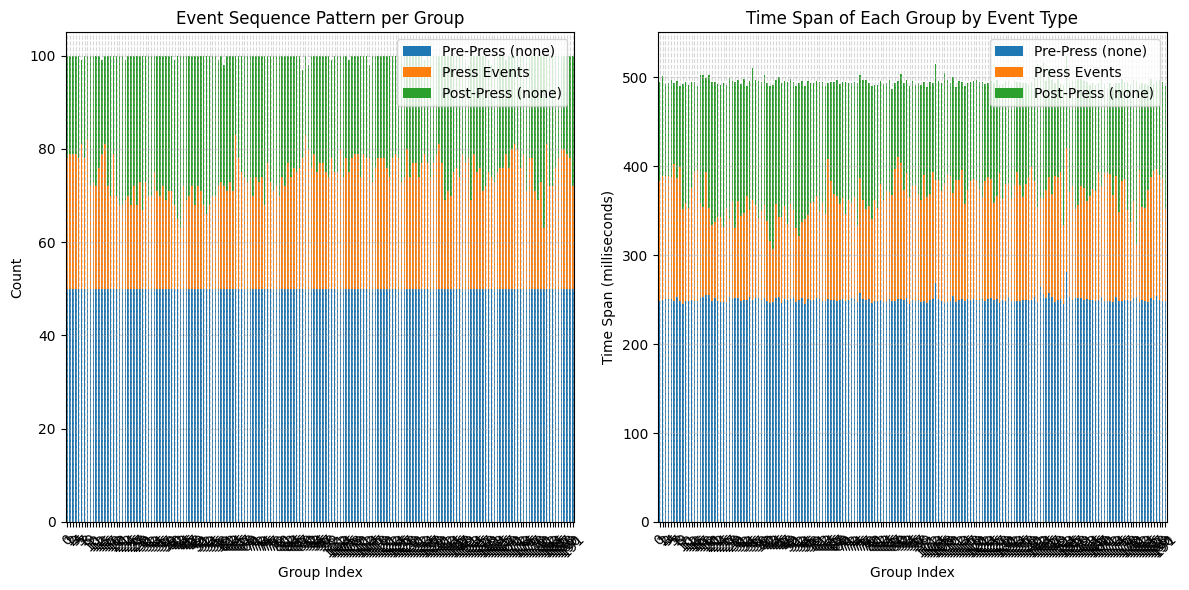

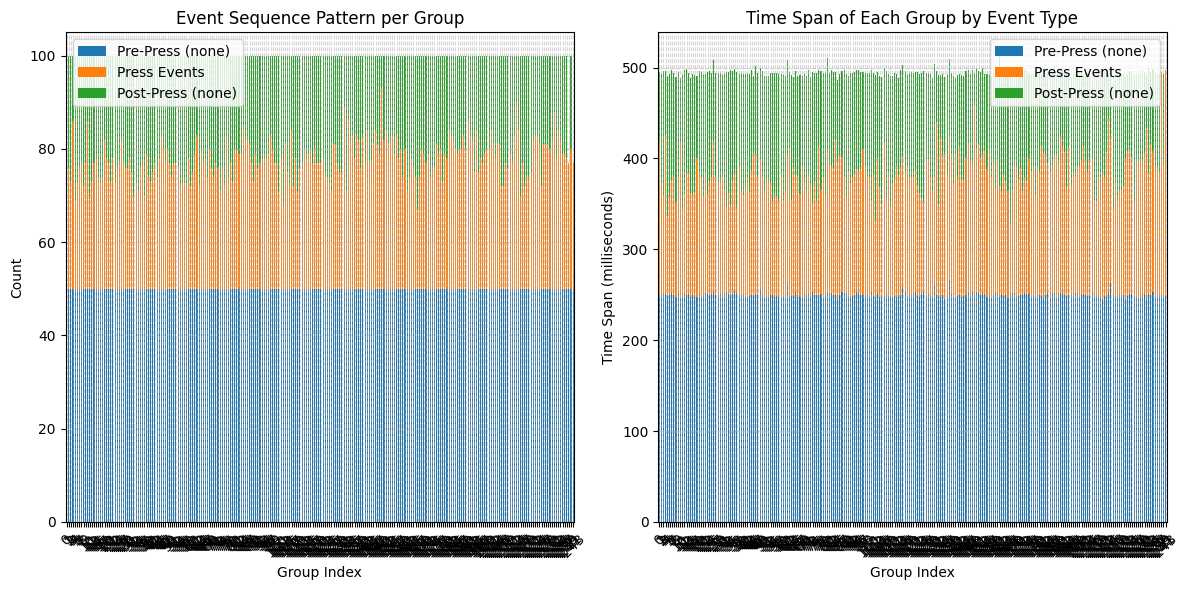

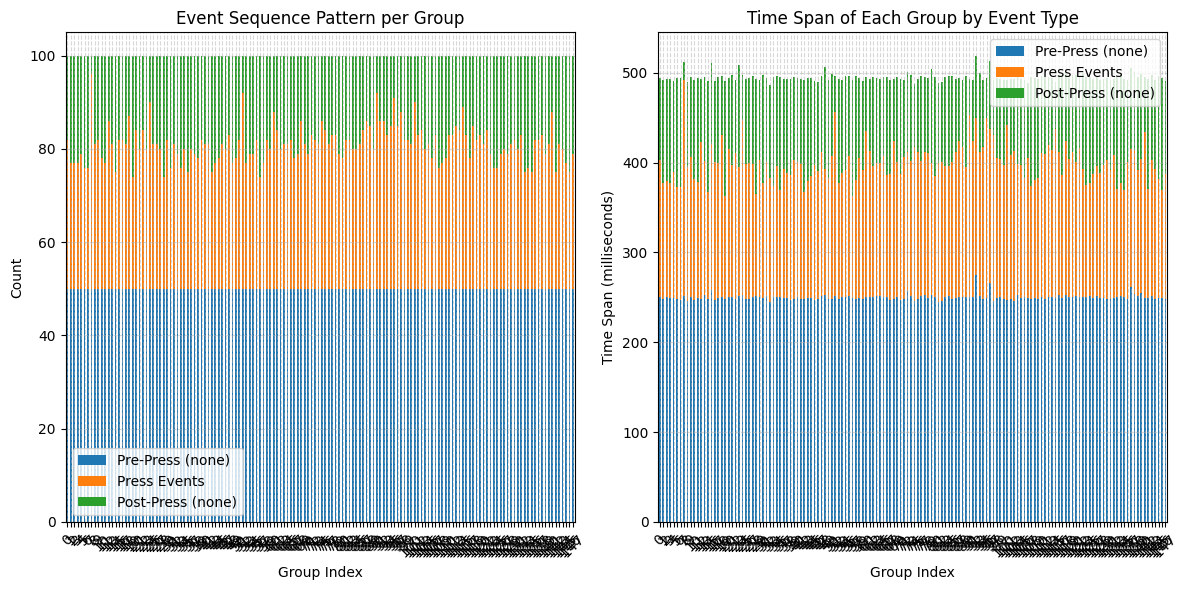

In [39]:
plot_event_durations(file_out)
plot_event_durations(folder_path+user2_pro_csv)
plot_event_durations(folder_path+user3_pro_csv)
plot_event_durations(folder_path+user4_pro_csv)


In [48]:
# Function to plot the inertial sensor data over time
def plot_inertial_data(file_path):
    """
    Plot the gyroscope and accelerometer data over time to visualize motion patterns.
    
    Args:
        file_path: Path to the CSV file containing controller data with timestamp and sensor readings
    """
    # Load the data from CSV file
    df = pd.read_csv(file_path)
    
    # Create a figure with two rows of subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Convert timestamp to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Plot gyroscope data (top subplot)
    axes[0].plot(df['timestamp'], df['gyro_pitch'], label='Pitch', color='#1f77b4')
    axes[0].plot(df['timestamp'], df['gyro_yaw'], label='Yaw', color='#ff7f0e')
    axes[0].plot(df['timestamp'], df['gyro_roll'], label='Roll', color='#2ca02c')
    axes[0].set_ylabel('Gyroscope Reading')
    axes[0].set_title('Gyroscope Data Over Time')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot accelerometer data (bottom subplot)
    axes[1].plot(df['timestamp'], df['acc_x'], label='X-axis', color='#d62728')
    axes[1].plot(df['timestamp'], df['acc_y'], label='Y-axis', color='#9467bd')
    axes[1].plot(df['timestamp'], df['acc_z'], label='Z-axis', color='#8c564b')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Accelerometer Reading')
    axes[1].set_title('Accelerometer Data Over Time')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    # Highlight button press events if they exist
    if 'button_press' in df.columns:
        press_events = df[df['button_press'] != 'none']
        if not press_events.empty:
            for ax in axes:
                for idx, event in press_events.iterrows():
                    ax.axvline(x=event['timestamp'], color='red', alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    plt.show()



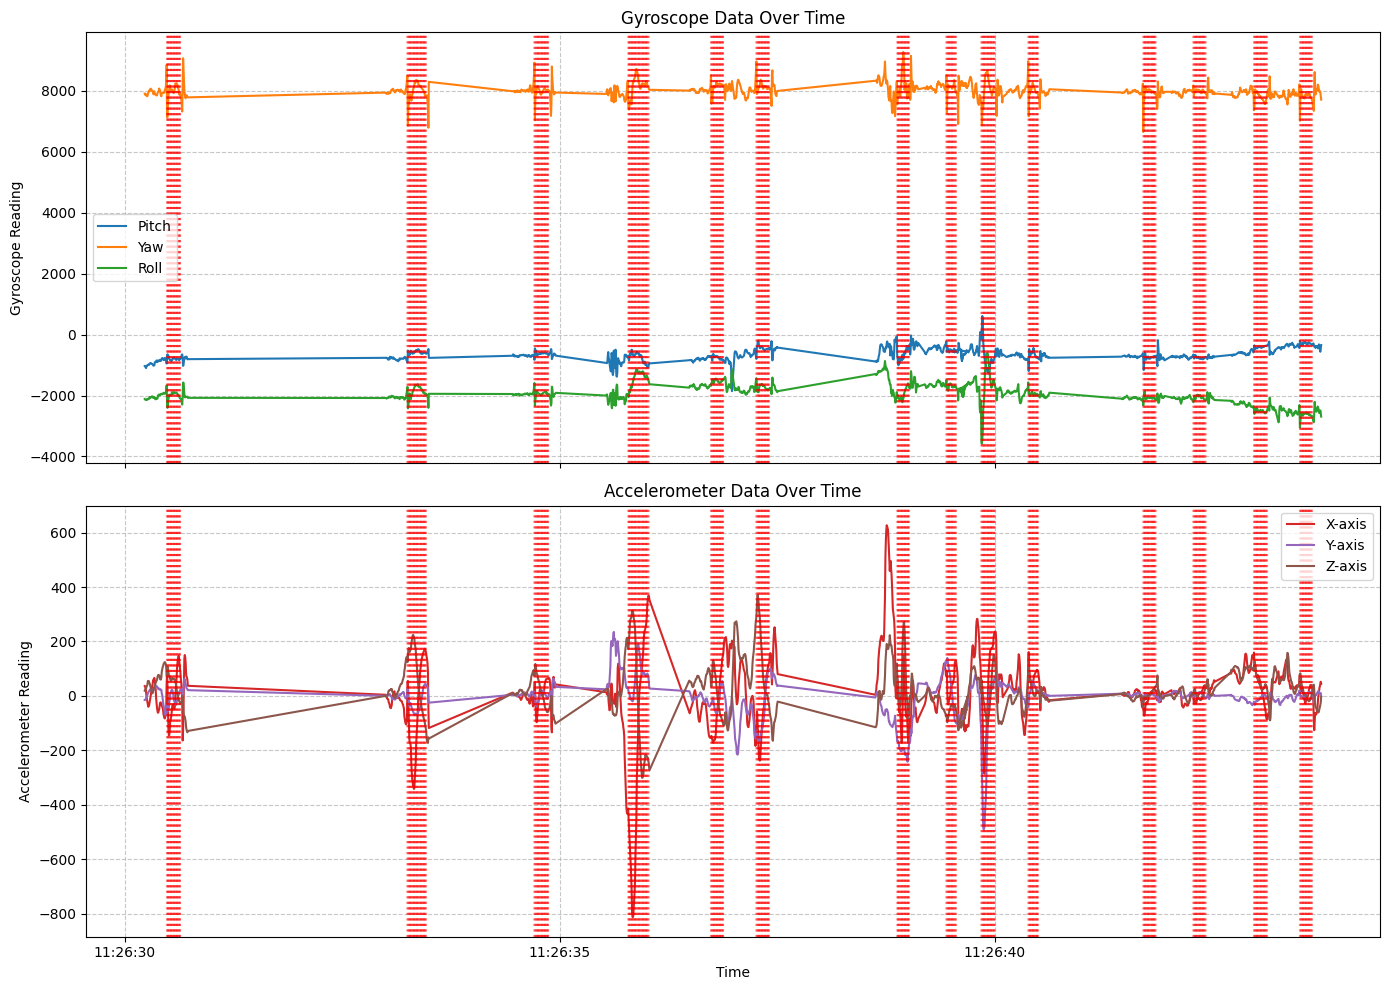

In [49]:
# Plot the inertial data from the loaded file
plot_inertial_data(file_out)

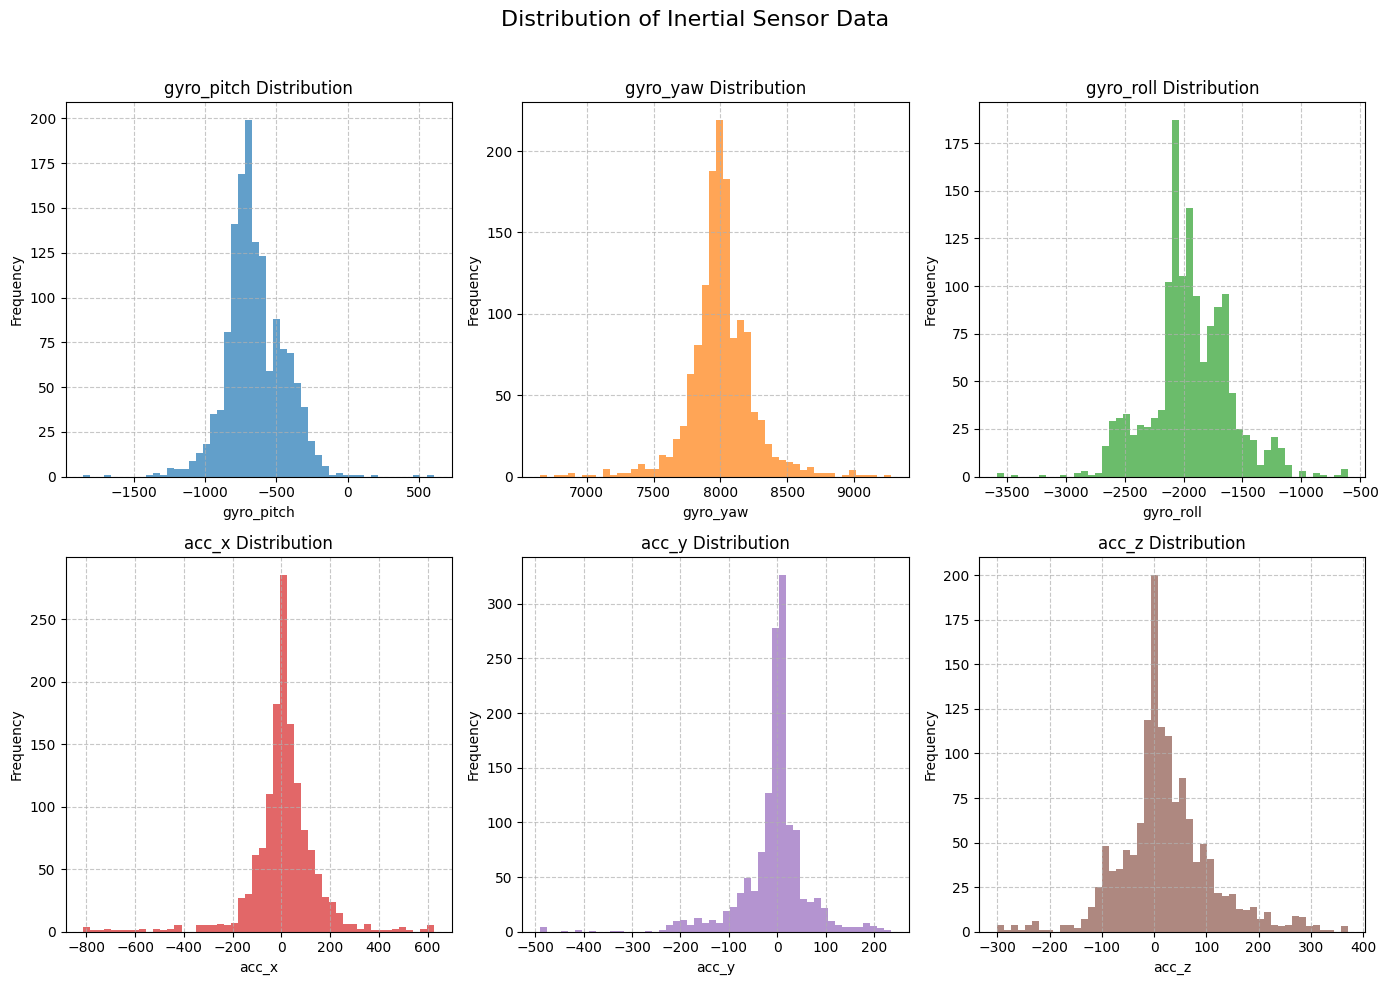

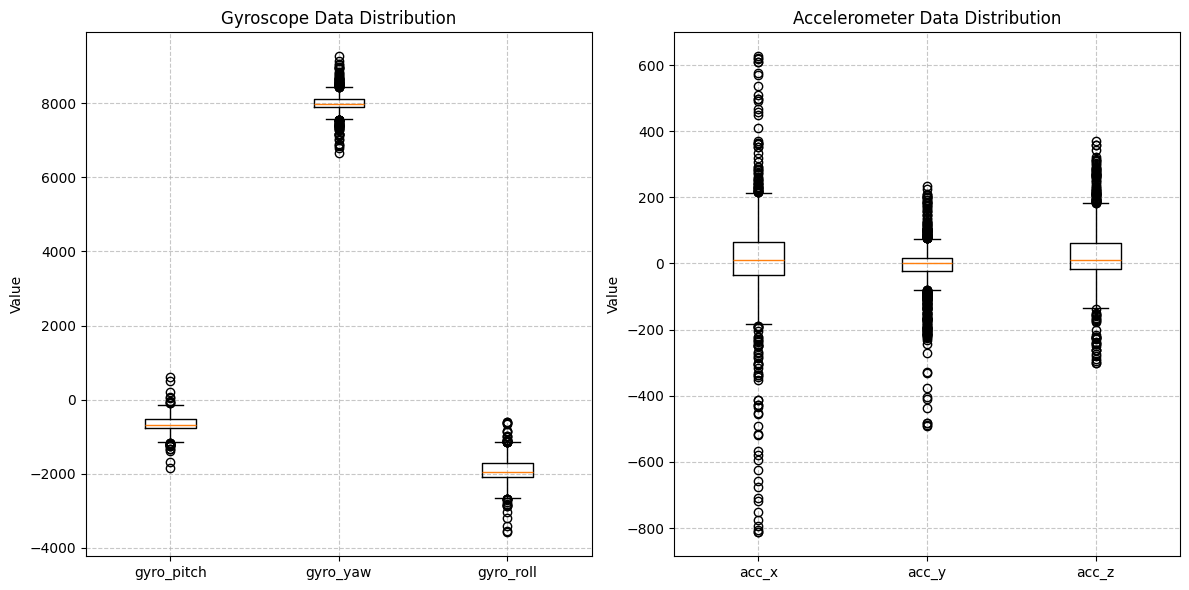

In [52]:
# distribution of inertial data 
def plot_inertial_distributions(df):
    """
    Plot distributions of inertial data (gyroscope and accelerometer) from a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing gyroscope and accelerometer data columns
    """
    # Check if the required columns exist
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return
    
    # Create a figure with 6 subplots for individual distributions
    fig, axes = plt.subplots(2, 3, figsize=(14, 10))
    fig.suptitle('Distribution of Inertial Sensor Data', fontsize=16)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Plot histograms for each sensor attribute
    for i, col in enumerate(required_cols):
        axes[i].hist(df[col], bins=50, color=f'C{i}', alpha=0.7)
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()
    
    # Create a boxplot to show all distributions together
    plt.figure(figsize=(12, 6))
    
    # Create separate boxplots for gyroscope and accelerometer data due to different scales
    plt.subplot(1, 2, 1)
    gyro_data = df[['gyro_pitch', 'gyro_yaw', 'gyro_roll']]
    plt.boxplot(gyro_data.values, tick_labels=gyro_data.columns)
    plt.title('Gyroscope Data Distribution')
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    acc_data = df[['acc_x', 'acc_y', 'acc_z']]
    plt.boxplot(acc_data.values, tick_labels=acc_data.columns)
    plt.title('Accelerometer Data Distribution')
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Plot the distribution of inertial data from the loaded file
out_df=pd.read_csv(file_out)
plot_inertial_distributions(out_df)


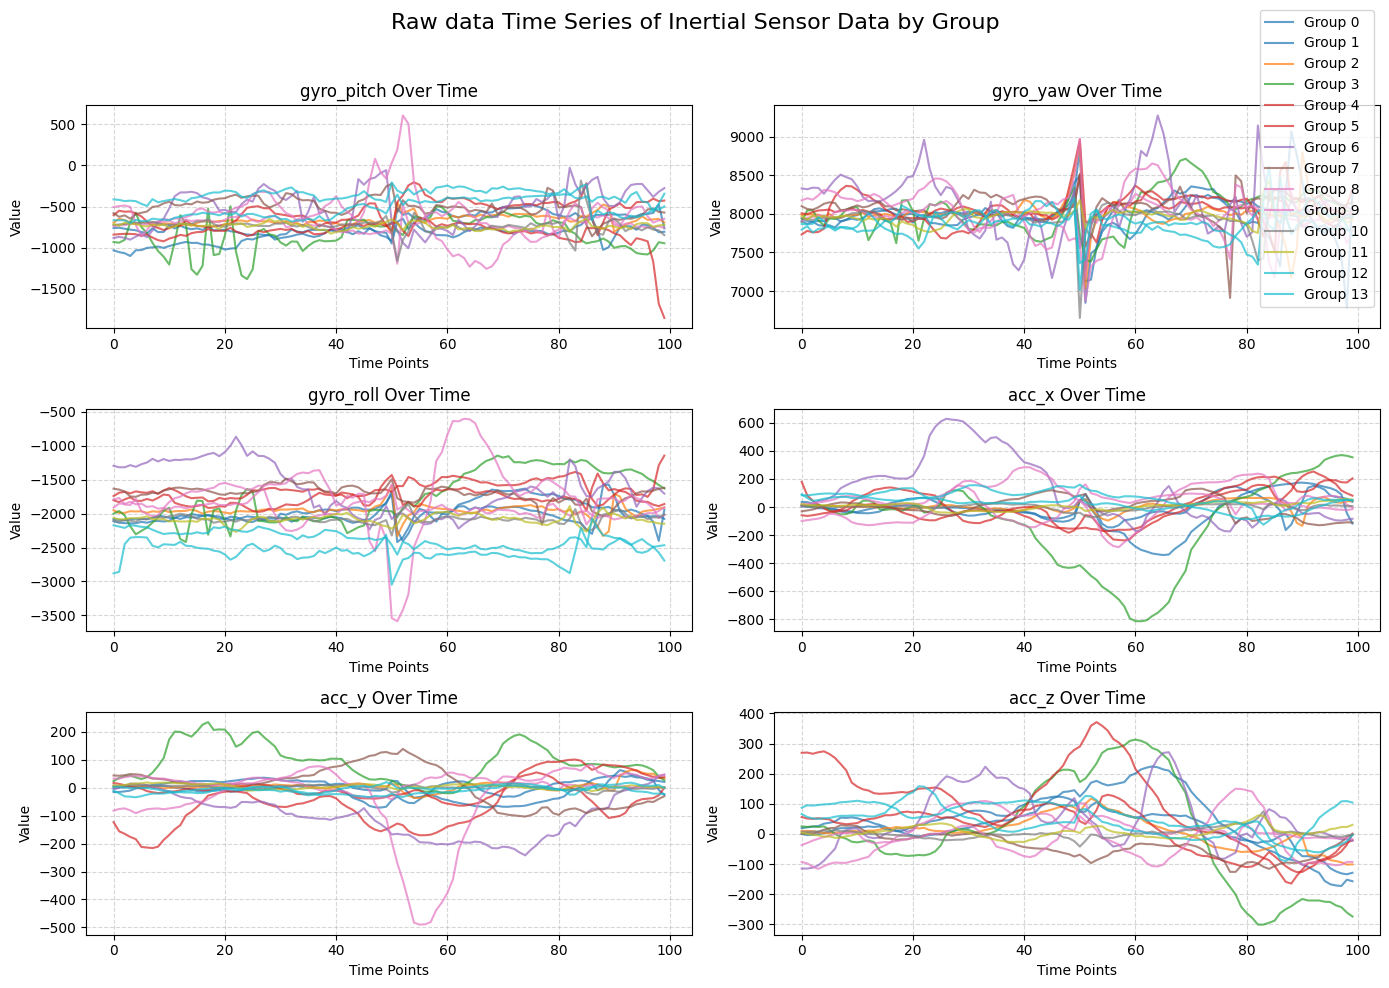

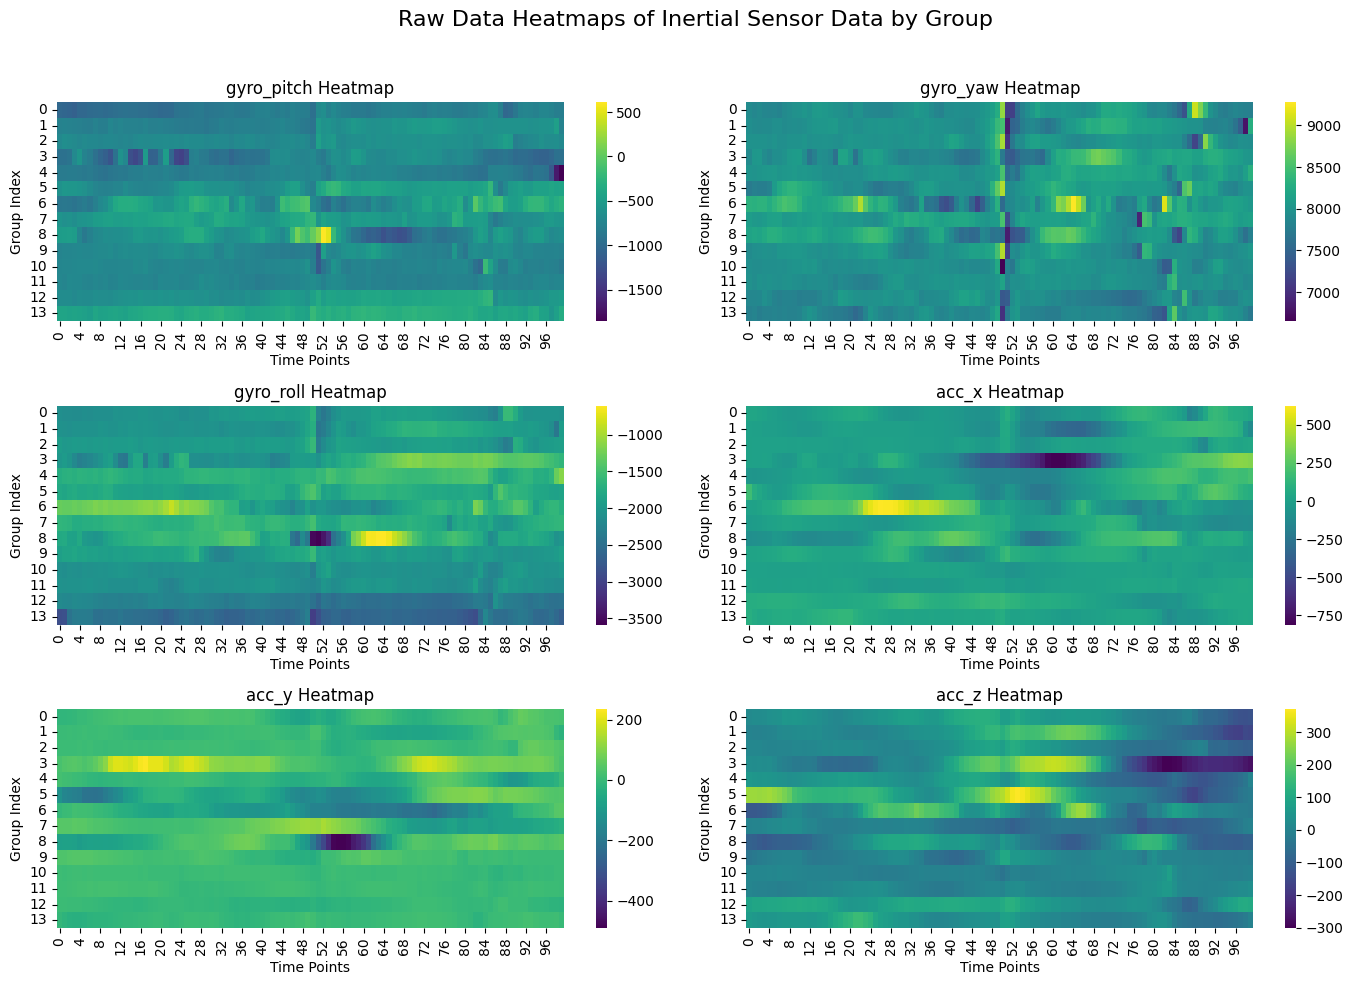

In [55]:
# plot all the group in one time-series 

def plot_groups_time_series(df,plotname=''):
    """
    Plot time-series data for all groups, with each group represented by a different color.
    Creates 6 subplots, one for each inertial attribute.
    """
    if 'group_index' not in df.columns:
        print("Error: 'group_index' column not found in DataFrame")
        return
    
    # Check for required columns
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return
    
    # Create a figure with 6 subplots for each attribute
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'{plotname} Time Series of Inertial Sensor Data by Group', fontsize=16)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Get unique groups
    groups = df['group_index'].unique()
    
    # Create a color map for different groups
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    # Plot each attribute
    for i, col in enumerate(required_cols):
        for j, group in enumerate(groups):
            group_data = df[df['group_index'] == group]
            axes[i].plot(range(len(group_data)), group_data[col], 
                         color=colors[j], label=f'Group {group}', alpha=0.7)
        
        axes[i].set_title(f'{col} Over Time')
        axes[i].set_xlabel('Time Points')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.99, 0.99))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()


def plot_groups_heatmaps(df, plotname=''):
    """
    Plot heatmaps for each inertial attribute across all groups.
    Each heatmap shows the time-series data where rows represent different groups (actions)
    and columns represent time points.
    """
    if 'group_index' not in df.columns:
        print("Error: 'group_index' column not found in DataFrame")
        return

    # Check for required columns
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return

    # Create a figure with 6 subplots for each attribute
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'{plotname} Heatmaps of Inertial Sensor Data by Group', fontsize=16)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Get unique groups sorted for consistent ordering
    groups = sorted(df['group_index'].unique())

    # Loop over each attribute to create its heatmap
    for i, col in enumerate(required_cols):
        # Build a 2D matrix where each row is the time-series for one group
        data_matrix = []
        for group in groups:
            group_data = df[df['group_index'] == group][col].values
            data_matrix.append(group_data)
        data_matrix = np.array(data_matrix)

        # Plot the heatmap for this attribute
        sns.heatmap(data_matrix, ax=axes[i], cmap='viridis', cbar=True)
        axes[i].set_title(f'{col} Heatmap')
        axes[i].set_xlabel('Time Points')
        axes[i].set_ylabel('Group Index')
        # Adjust y-axis ticks to be centered on each heatmap row
        axes[i].set_yticks(np.arange(len(groups)) + 0.5)
        axes[i].set_yticklabels(groups)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Plot time-series data for all groups
plot_groups_time_series(out_df,plotname='Raw data')
plot_groups_heatmaps(out_df,'Raw Data')

### 1.5 Visual for one btn

In [56]:
cross_btn_csv="controller_data_user1_20250309_202625_cr_btn.csv"
csv_folder='../data/'

In [57]:

extract_press_events(csv_folder+cross_btn_csv,csv_folder+'cross_btn_press_events.csv')


Extracted data saved to ../data/cross_btn_press_events.csv


In [74]:
crs_btn_csv_ext='../data/controller_data_user1_20250309_202625_cr_btn_pro.csv'



In [62]:
import numpy as np
import matplotlib.pyplot as plt

def plot_groups_time_series_same_btn(df, plotname=''):
    """
    Plot time-series data for all groups, using the same color for all lines.
    Adds transparency to show the density of overlapping curves and plots the mean with standard deviation.
    Creates 6 subplots, one for each inertial attribute.
    """
    if 'group_index' not in df.columns:
        print("Error: 'group_index' column not found in DataFrame")
        return
    
    # Check for required columns
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return
    
    # Create a figure with 6 subplots for each attribute
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'{plotname} Time Series of Inertial Sensor Data', fontsize=16)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Get unique groups
    groups = df['group_index'].unique()
    
    # Define a single color for all groups
    line_color = 'blue'  # Change this to any preferred color
    
    # Plot each attribute
    for i, col in enumerate(required_cols):
        all_group_data = []
        
        for group in groups:
            group_data = df[df['group_index'] == group][col].values
            all_group_data.append(group_data)
            axes[i].plot(range(len(group_data)), group_data, 
                         color=line_color, alpha=0.2)  # Use transparency
        
        # Compute mean and standard deviation
        all_group_data = np.array(all_group_data)
        mean_values = np.mean(all_group_data, axis=0)
        std_values = np.std(all_group_data, axis=0)
        
        # Plot mean with standard deviation as a shaded region
        axes[i].plot(range(len(mean_values)), mean_values, color='red', label='Mean')
        axes[i].fill_between(range(len(mean_values)), mean_values - std_values, mean_values + std_values,
                             color='red', alpha=0.3, label='Std Dev')
        
        axes[i].set_title(f'{col} Over Time')
        axes[i].set_xlabel('Time Points')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

In [75]:
crs_df=pd.read_csv(crs_btn_csv_ext)

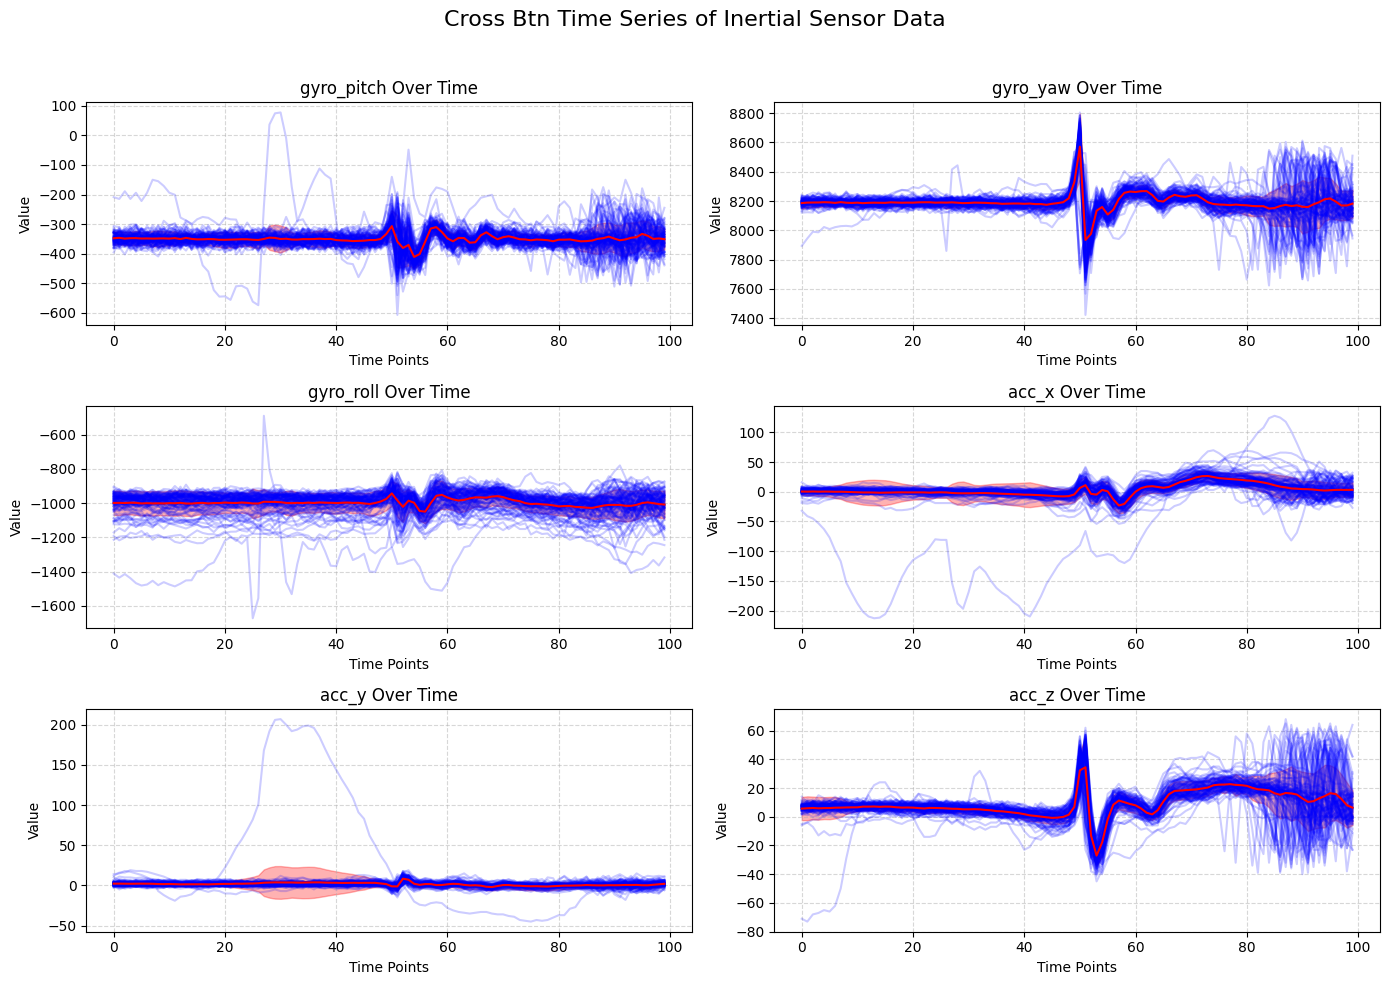

In [63]:

plot_groups_time_series_same_btn(crs_df,'Cross Btn')

#### 1.3.1 Compare the different user data 


##### 1.3.1.1 Plot 1 Raw data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_compare_time_series(df_list, labels=None, plotname='', alldata=False, save_latex=False):
    """
    Compare time-series data from multiple datasets, plotting them in different colors.
    Adds transparency to show the density of overlapping curves and plots the mean with standard deviation.
    Creates 6 subplots, one for each inertial attribute.
    
    Parameters:
    - df_list: List of DataFrames containing the time-series data
    - labels: List of labels for each dataset (defaults to 'Dataset 1', 'Dataset 2', etc.)
    - plotname: Title for the plot
    - alldata: If True, shows all individual lines; if False, only shows mean and std dev
    - save_latex: If True, saves the figure as a PDF file for LaTeX inclusion
    """
    # Validate inputs
    if not isinstance(df_list, list) or len(df_list) == 0:
        print("Error: df_list must be a non-empty list of DataFrames")
        return
    
    # Create default labels if not provided
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(df_list))]
    elif len(labels) != len(df_list):
        print("Warning: Number of labels doesn't match number of datasets. Using default labels.")
        labels = [f'Dataset {i+1}' for i in range(len(df_list))]
    
    # Check for required columns in all dataframes
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for i, df in enumerate(df_list):
        if 'group_index' not in df.columns:
            print(f"Error: 'group_index' column not found in DataFrame {i+1}")
            return
        for col in required_cols:
            if col not in df.columns:
                print(f"Error: Column '{col}' not found in DataFrame {i+1}")
                return
    
    # Create a figure with 6 subplots for each attribute
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'{plotname} Time Series Comparison of Inertial Sensor Data', fontsize=16)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Define a list of colors for datasets
    colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta']
    mean_colors = ['red', 'orange', 'darkviolet', 'darkgreen', 'darkblue', 'crimson', 'black', 'darkred', 'teal', 'navy']
    
    # Ensure we have enough colors
    if len(df_list) > len(colors):
        print(f"Warning: Only {len(colors)} unique colors available for {len(df_list)} datasets.")
    
    # Plot each attribute
    for i, col in enumerate(required_cols):
        # Process each dataset
        for df_idx, df in enumerate(df_list):
            # Use modulo to cycle through colors if we have more datasets than colors
            color_idx = df_idx % len(colors)
            
            all_group_data = []
            
            # Plot individual lines if alldata is True
            for group in df['group_index'].unique():
                group_data = df[df['group_index'] == group][col].values
                all_group_data.append(group_data)
                if alldata:
                    axes[i].plot(range(len(group_data)), group_data, 
                                color=colors[color_idx], alpha=0.1)
            
            # Compute mean and std for the dataset
            all_group_data = np.array(all_group_data)
            mean_values = np.mean(all_group_data, axis=0)
            std_values = np.std(all_group_data, axis=0)
            
            # Plot mean and std for the dataset
            axes[i].plot(range(len(mean_values)), mean_values, 
                        color=mean_colors[color_idx], label=f'{labels[df_idx]} Mean')
            axes[i].fill_between(range(len(mean_values)), 
                                mean_values - std_values, 
                                mean_values + std_values,
                                color=mean_colors[color_idx], alpha=0.1)
        
        axes[i].set_title(f'{col} Over Time')
        axes[i].set_xlabel('Time Points')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, linestyle='--', alpha=0.1)
        axes[i].legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    
    # Save the figure for LaTeX if requested
    if save_latex:
        # Create a filename based on the plotname
        filename = f"time_series_comparison_{plotname.replace(' ', '_').lower()}.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight')
        print(f"Figure saved as {filename} for LaTeX inclusion")
    
    plt.show()


#### Read Data 

In [26]:
import pandas as pd
csv_user1="../data/controller_data_user1_20250309_202625_cr_btn_pro.csv"
csv_user2="../data/controller_data_user2_20250310_100504_pro_filtered.csv"
csv_user3="../data/controller_data_user3_20250310_100733_pro_filtered.csv"
csv_user4="../data/controller_data_user4_20250310_101102_pro_filtered.csv"

df_user1=pd.read_csv(csv_user1)
df_user2=pd.read_csv(csv_user2)
df_user3=pd.read_csv(csv_user3)
df_user4=pd.read_csv(csv_user4)


df_users_list=[df_user1,df_user2,df_user3,df_user4]
labels_list=['User 1','User 2','User 3', 'User 4']


Figure saved as time_series_comparison_compare_observation.pdf for LaTeX inclusion


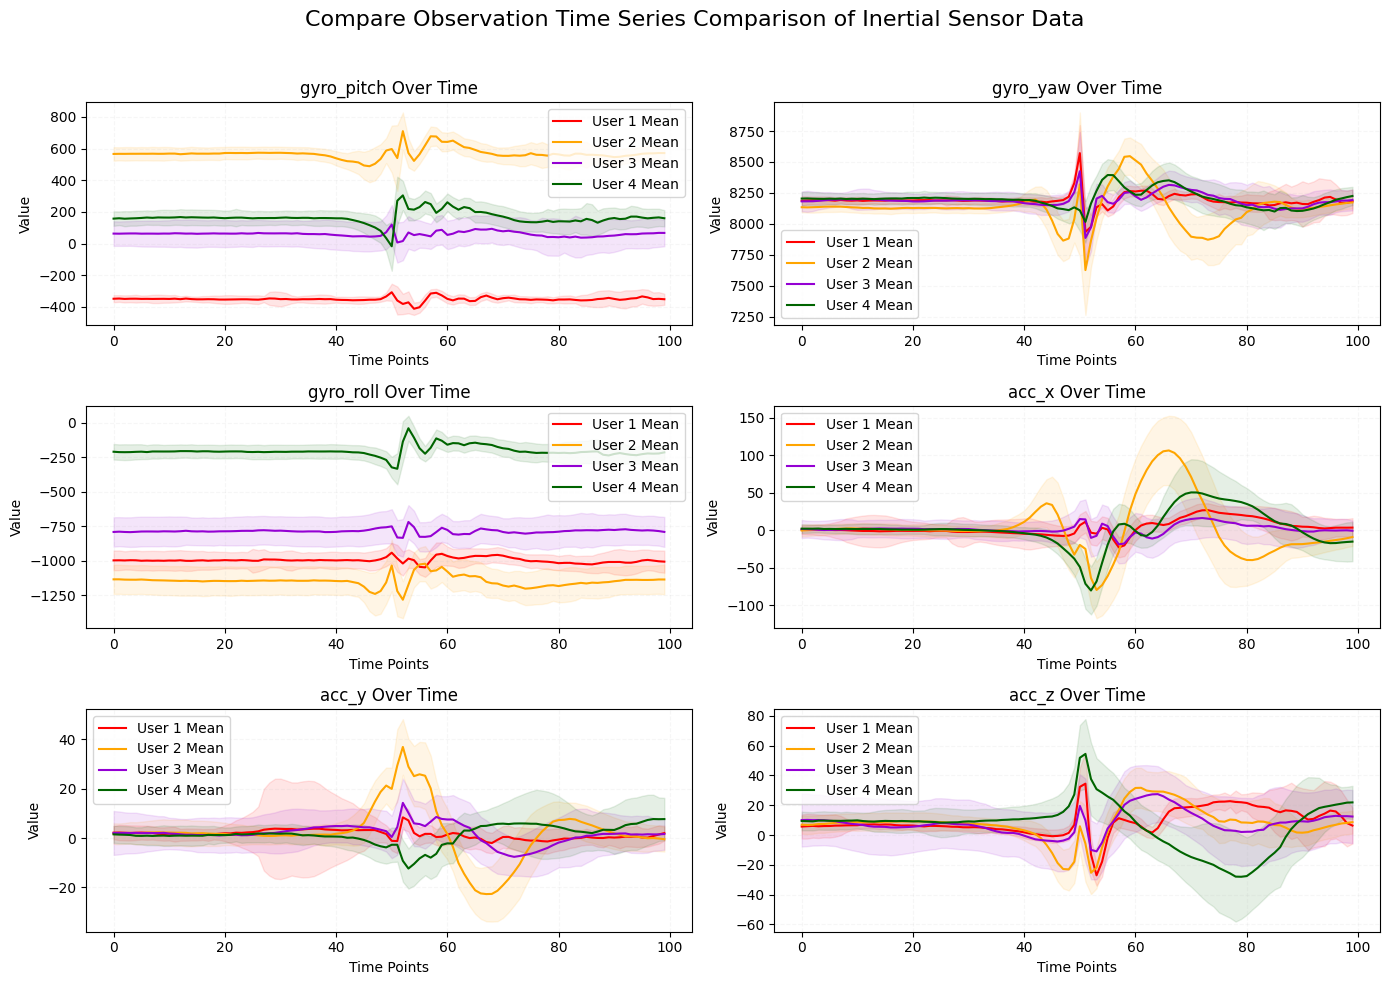

In [3]:
plot_compare_time_series(df_users_list,labels_list,plotname='Compare Observation',save_latex=True)

##### 1.3.1.2 Plot2 Amplifu time

- min-max normalization each 6D,
- amplifide- time


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_min_max(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def compute_amplitude(acc_x, acc_y, acc_z, gyro_p, gyro_y, gyro_r):
    acc_amp = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    gyro_amp = np.sqrt(gyro_p**2 + gyro_y**2 + gyro_r**2)
    return acc_amp, gyro_amp

def plot_normalized_data(df_list, labels=None, plotname='', save_latex=False):
    if not isinstance(df_list, list) or len(df_list) == 0:
        print("Error: df_list must be a non-empty list of DataFrames")
        return
    
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(df_list))]
    elif len(labels) != len(df_list):
        print("Warning: Number of labels doesn't match number of datasets. Using default labels.")
        labels = [f'Dataset {i+1}' for i in range(len(df_list))]
    
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for i, df in enumerate(df_list):
        for col in required_cols:
            if col not in df.columns:
                print(f"Error: Column '{col}' not found in DataFrame {i+1}")
                return
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'{plotname} Normalized Sensor Data by Dimension', fontsize=16)
    
    # Flatten axes for easier indexing
    axes = axes.flatten()
    
    # Define colors for each user
    colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink']
    
    # Map each sensor to its subplot
    sensor_map = {
        'acc_x': 0,
        'acc_y': 1,
        'acc_z': 2,
        'gyro_pitch': 3,
        'gyro_yaw': 4,
        'gyro_roll': 5
    }
    
    # Plot titles
    titles = [
        'Accelerometer X', 'Accelerometer Y', 'Accelerometer Z',
        'Gyroscope Pitch', 'Gyroscope Yaw', 'Gyroscope Roll'
    ]
    
    # Process each sensor dimension
    for sensor, ax_idx in sensor_map.items():
        ax = axes[ax_idx]
        ax.set_title(titles[ax_idx])
        ax.set_xlabel('Time Points')
        ax.set_ylabel('Normalized Value')
        ax.grid(True, linestyle='--', alpha=0.2)
        
        # Process each user's data
        for df_idx, df in enumerate(df_list):
            color_idx = df_idx % len(colors)
            all_sensor_data = []
            
            # Process each group (session) for the current user
            for group in df['group_index'].unique():
                group_data = df[df['group_index'] == group]
                # Normalize the sensor data for this group
                normalized_data = normalize_min_max(group_data[sensor].values)
                all_sensor_data.append(normalized_data)
            
            all_sensor_data = np.array(all_sensor_data)
            mean_data = np.mean(all_sensor_data, axis=0)
            std_data = np.std(all_sensor_data, axis=0)
            
            # Plot mean line
            ax.plot(range(len(mean_data)), mean_data, color=colors[color_idx], 
                    label=f'{labels[df_idx]}')
            
            # Plot standard deviation as shaded area
            ax.fill_between(range(len(mean_data)), 
                           mean_data - std_data, 
                           mean_data + std_data, 
                           color=colors[color_idx], alpha=0.2)
    
    # Add a single legend for the entire figure
    handles, labels_legend = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels_legend, loc='upper right', bbox_to_anchor=(0.99, 0.99))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_latex:
        filename = f"normalized_data_{plotname.replace(' ', '_').lower()}.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight')
        print(f"Figure saved as {filename} for LaTeX inclusion")
    
    plt.show()
    
    # Create a second figure for amplitude plots
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))
    fig2.suptitle(f'{plotname} Sensor Amplitude', fontsize=16)
    
    # Process each user's data for amplitude plots
    for df_idx, df in enumerate(df_list):
        color_idx = df_idx % len(colors)
        all_acc_amp = []
        all_gyro_amp = []
        
        # Process each group (session) for the current user
        for group in df['group_index'].unique():
            group_data = df[df['group_index'] == group]
            
            # Compute amplitudes
            acc_amp, gyro_amp = compute_amplitude(
                group_data['acc_x'].values,
                group_data['acc_y'].values,
                group_data['acc_z'].values,
                group_data['gyro_pitch'].values,
                group_data['gyro_yaw'].values,
                group_data['gyro_roll'].values
            )
            
            # Normalize amplitudes
            acc_amp_norm = normalize_min_max(acc_amp)
            gyro_amp_norm = normalize_min_max(gyro_amp)
            
            all_acc_amp.append(acc_amp_norm)
            all_gyro_amp.append(gyro_amp_norm)
        
        # Calculate mean and std for amplitudes
        all_acc_amp = np.array(all_acc_amp)
        all_gyro_amp = np.array(all_gyro_amp)
        
        mean_acc_amp = np.mean(all_acc_amp, axis=0)
        std_acc_amp = np.std(all_acc_amp, axis=0)
        
        mean_gyro_amp = np.mean(all_gyro_amp, axis=0)
        std_gyro_amp = np.std(all_gyro_amp, axis=0)
        
        # Plot accelerometer amplitude
        axes2[0].plot(range(len(mean_acc_amp)), mean_acc_amp, color=colors[color_idx], 
                     label=f'{labels[df_idx]}')
        axes2[0].fill_between(range(len(mean_acc_amp)), 
                             mean_acc_amp - std_acc_amp, 
                             mean_acc_amp + std_acc_amp, 
                             color=colors[color_idx], alpha=0.2)
        
        # Plot gyroscope amplitude
        axes2[1].plot(range(len(mean_gyro_amp)), mean_gyro_amp, color=colors[color_idx], 
                     label=f'{labels[df_idx]}')
        axes2[1].fill_between(range(len(mean_gyro_amp)), 
                             mean_gyro_amp - std_gyro_amp, 
                             mean_gyro_amp + std_gyro_amp, 
                             color=colors[color_idx], alpha=0.2)
    
    # Set titles and labels for amplitude plots
    axes2[0].set_title('Accelerometer Amplitude')
    axes2[0].set_xlabel('Time Points')
    axes2[0].set_ylabel('Normalized Amplitude')
    axes2[0].grid(True, linestyle='--', alpha=0.2)
    axes2[0].legend()
    
    axes2[1].set_title('Gyroscope Amplitude')
    axes2[1].set_xlabel('Time Points')
    axes2[1].set_ylabel('Normalized Amplitude')
    axes2[1].grid(True, linestyle='--', alpha=0.2)
    axes2[1].legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_latex:
        filename = f"amplitude_data_{plotname.replace(' ', '_').lower()}.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight')
        print(f"Figure saved as {filename} for LaTeX inclusion")
    
    plt.show()


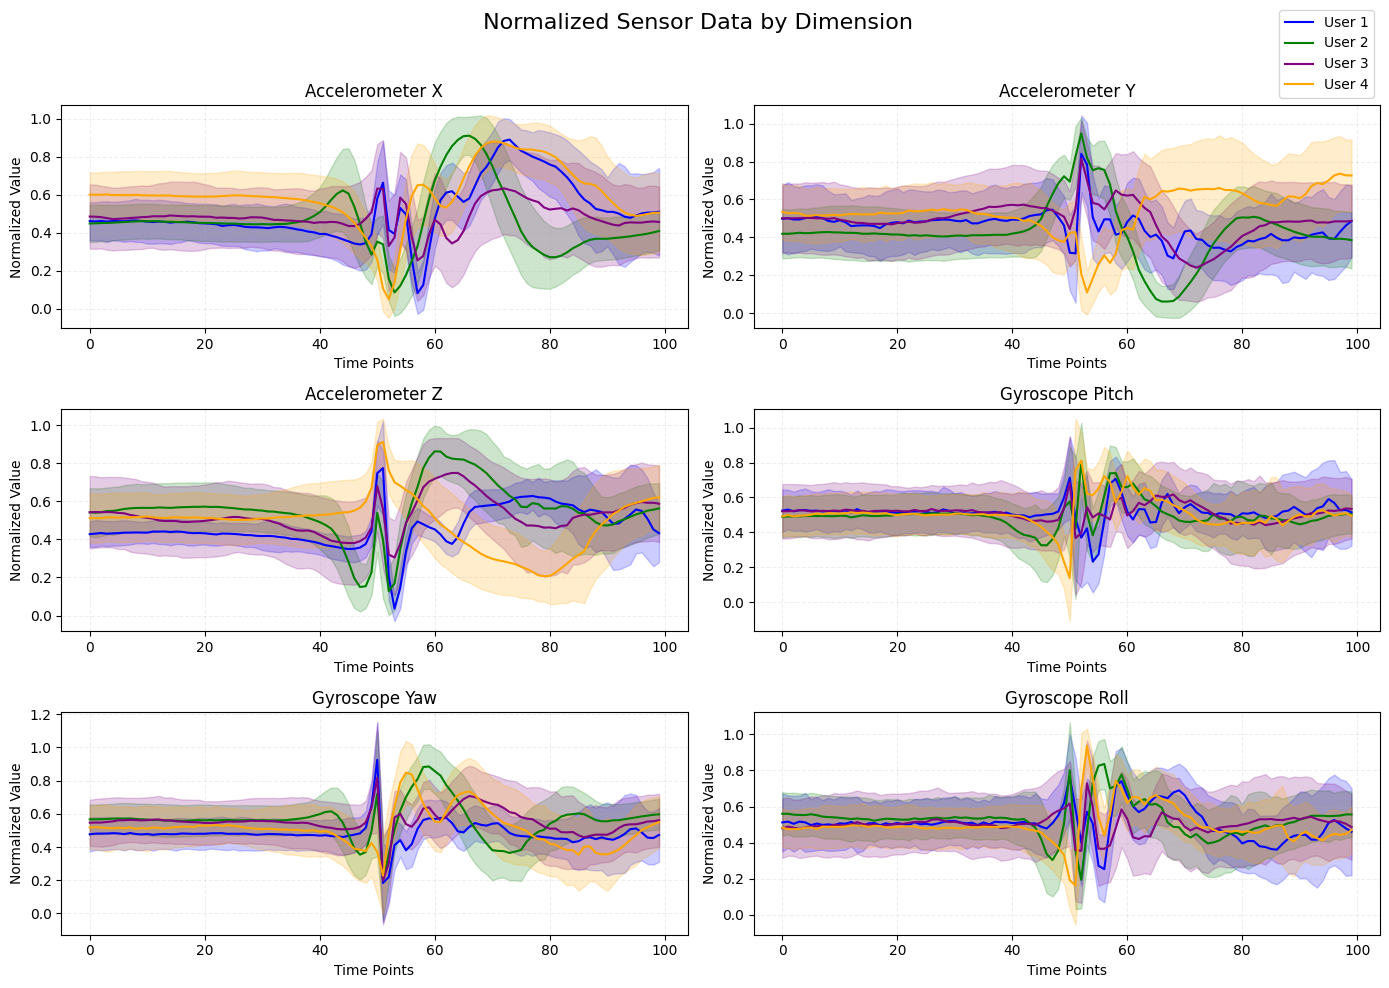

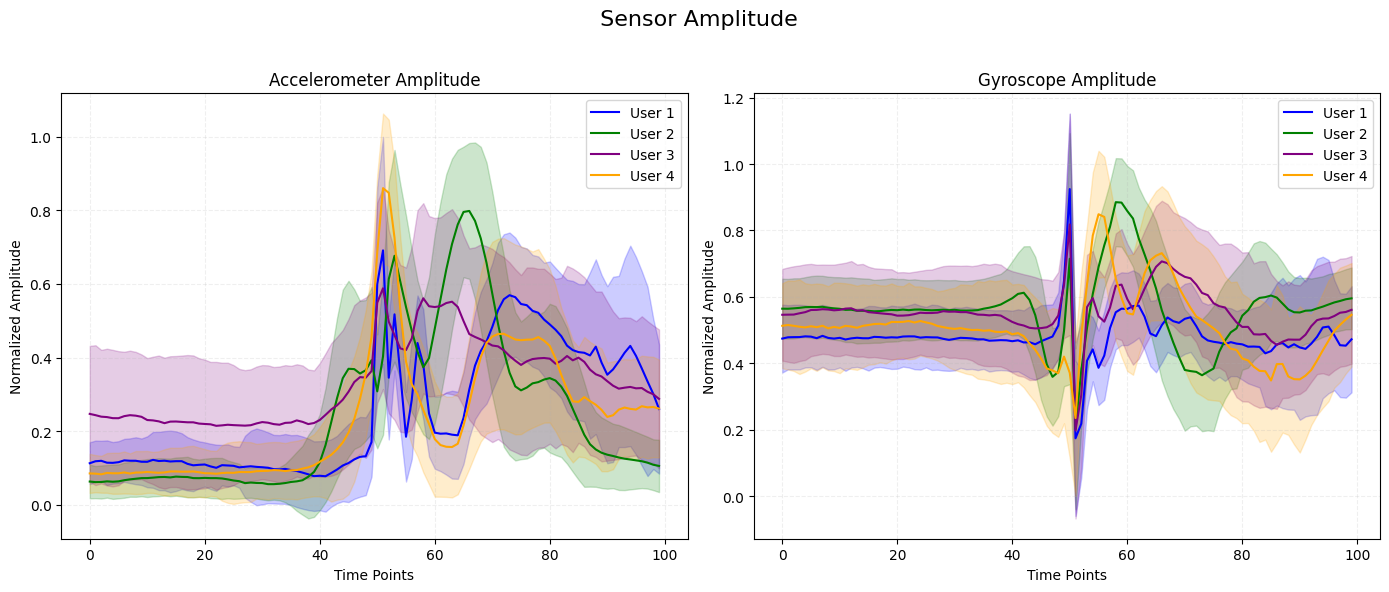

In [5]:
plot_normalized_data(df_users_list,labels_list)

##### 1.3.1.3 Seperate the phase - Pre press 
- pre-press:  0-40stable
- pressing:  40-80 peak, vally
- post-press 80-100


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def analyze_and_plot_norl_std_vari(df_list):
    processed_dfs = []
    
    for user_idx, df in enumerate(df_list):
        # Step 1: Extract first 40 records per group
        df = df.groupby('group_index').head(40)

        # Step 2: Normalize gyro and accelerometer data using a rolling window
        gyro_acc_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
        
        def rolling_min_max_norm(series):
            return (series - series.rolling(window=5, min_periods=1).min()) / \
                   (series.rolling(window=5, min_periods=1).max() - series.rolling(window=5, min_periods=1).min() + 1e-9)
        
        df[gyro_acc_cols] = df[gyro_acc_cols].apply(rolling_min_max_norm)

        # Step 3: Compute rolling standard deviation and variance
        for col in gyro_acc_cols:
            df[col + '_std'] = df[col].rolling(window=5, min_periods=1).std()
            df[col + '_var'] = df[col].rolling(window=5, min_periods=1).var()
        
        # Drop original gyro and acc columns
        df = df.drop(columns=gyro_acc_cols)

        # Add user ID column for identification in PCA plot
        df['user_id'] = user_idx
        processed_dfs.append(df)

    # Combine all user data
    final_df = pd.concat(processed_dfs, ignore_index=True)

    # Step 4: Aggregate features by 'group_index' (take mean per group)
    feature_cols = [col for col in final_df.columns if col not in ['timestamp', 'button_press', 'group_index', 'user_id']]
    
    # Group by 'user_id' and 'group_index', and calculate the mean for each group
    grouped_df = final_df.groupby(['user_id', 'group_index'])[feature_cols].mean().reset_index()

    # Step 5: PCA on aggregated group-level data
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(grouped_df[feature_cols])
    
    # Add PCA results to the grouped data
    grouped_df['pca1'] = pca_result[:, 0]
    grouped_df['pca2'] = pca_result[:, 1]
    
    # Step 6: Plot the PCA results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='pca1', y='pca2', hue='user_id', style='user_id', data=grouped_df, palette='tab10', alpha=0.7)
    plt.title("PCA Visualization of Grouped Data by User")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="User ID")
    plt.show()


    
    



C:\Users\lycaz\AppData\Local\Temp\ipykernel_26716\2707223754.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[gyro_acc_cols] = df[gyro_acc_cols].apply(rolling_min_max_norm)
C:\Users\lycaz\AppData\Local\Temp\ipykernel_26716\2707223754.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_std'] = df[col].rolling(window=5, min_periods=1).std()
C:\Users\lycaz\AppData\Local\Temp\ipykernel_26716\2707223754.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

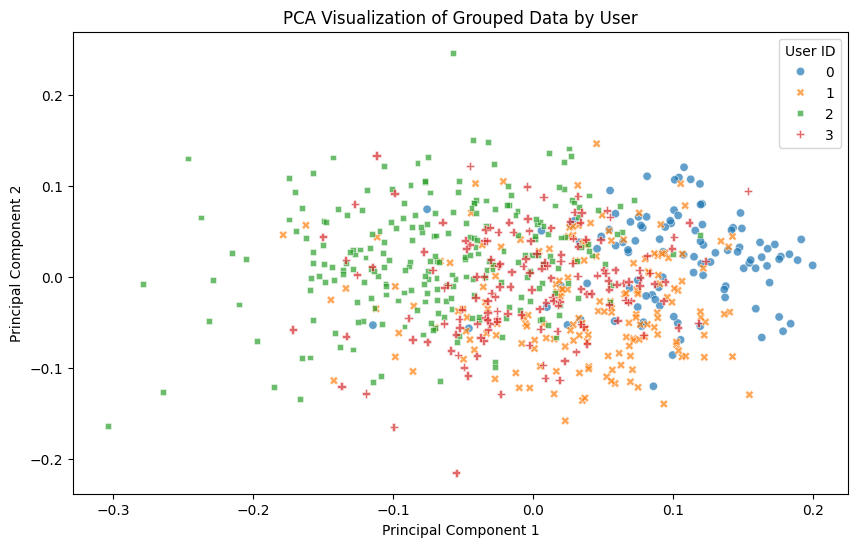

In [39]:
analyze_and_plot_norl_std_vari(df_users_list)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_std_variance_filled(df_list):
    # Process with first 40 records per group
    processed_dfs_40 = []
    processed_dfs_all = []
    
    for user_idx, df in enumerate(df_list):
        # Version 1: Extract first 40 records per group
        group_dfs_40 = []
        for group_id, group_data in df.groupby('group_index'):
            group_dfs_40.append(group_data.head(40).copy())
        
        # Combine all groups for this user (first 40 records)
        df_copy_40 = pd.concat(group_dfs_40, ignore_index=True)
        
        # Version 2: Use all records
        df_copy_all = df.copy()
        
        # Process both versions
        for df_copy, processed_dfs in [(df_copy_40, processed_dfs_40), (df_copy_all, processed_dfs_all)]:
            # Step 2: Normalize gyro and accelerometer data using a rolling window
            gyro_acc_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
            
            def rolling_min_max_norm(series):
                return (series - series.rolling(window=5, min_periods=1).min()) / \
                       (series.rolling(window=5, min_periods=1).max() - series.rolling(window=5, min_periods=1).min() + 1e-9)
            
            # Apply normalization using .loc to avoid SettingWithCopyWarning
            for col in gyro_acc_cols:
                df_copy.loc[:, col] = rolling_min_max_norm(df_copy[col])
            
            # Step 3: Compute rolling standard deviation and variance
            for col in gyro_acc_cols:
                df_copy.loc[:, col + '_std'] = df_copy[col].rolling(window=5, min_periods=1).std()
                df_copy.loc[:, col + '_var'] = df_copy[col].rolling(window=5, min_periods=1).var()
            
            # Drop original gyro and acc columns
            df_copy = df_copy.drop(columns=gyro_acc_cols)
            
            # Add user ID column for identification
            df_copy.loc[:, 'user_id'] = user_idx
            processed_dfs.append(df_copy)

    # Combine all user data for both versions
    final_df_40 = pd.concat(processed_dfs_40, ignore_index=True)
    final_df_all = pd.concat(processed_dfs_all, ignore_index=True)

    # Process both versions
    feature_cols = [col for col in final_df_40.columns if col not in ['timestamp', 'button_press', 'group_index', 'user_id']]
    
    # Add record position for both versions
    final_df_40.loc[:, 'record_position'] = final_df_40.groupby(['user_id', 'group_index']).cumcount()
    final_df_all.loc[:, 'record_position'] = final_df_all.groupby(['user_id', 'group_index']).cumcount()
    
    # Create multi-index DataFrames with the aggregated statistics
    grouped_df_40 = final_df_40.groupby(['user_id', 'group_index', 'record_position'])[feature_cols].agg(['mean', 'std']).reset_index()
    grouped_df_all = final_df_all.groupby(['user_id', 'group_index', 'record_position'])[feature_cols].agg(['mean', 'std']).reset_index()
    
    # Plot mean and standard deviation of standard deviation and variance
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    stat_cols = ['gyro_pitch_std', 'gyro_yaw_std', 'gyro_roll_std', 'acc_x_std', 'acc_y_std', 'acc_z_std']
    colors = sns.color_palette('tab10', len(df_list))
    
    # Plot for first 40 records and all records
    for user_idx_int, (user_df_40, user_df_all) in enumerate(zip(
            [grouped_df_40[grouped_df_40['user_id'] == i] for i in range(len(df_list))],
            [grouped_df_all[grouped_df_all['user_id'] == i] for i in range(len(df_list))]
        )):
        
        color = colors[user_idx_int]
        
        for i, col in enumerate(stat_cols):
            # First 40 records
            position_stats_40 = user_df_40.groupby('record_position').agg({
                (col, 'mean'): 'mean',
                (col, 'std'): 'mean'
            }).reset_index()
            
            mean_values_40 = position_stats_40[(col, 'mean')]
            std_values_40 = position_stats_40[(col, 'std')]
            x_values_40 = position_stats_40['record_position']
            
            # All records
            position_stats_all = user_df_all.groupby('record_position').agg({
                (col, 'mean'): 'mean',
                (col, 'std'): 'mean'
            }).reset_index()
            
            mean_values_all = position_stats_all[(col, 'mean')]
            std_values_all = position_stats_all[(col, 'std')]
            x_values_all = position_stats_all['record_position']
            
            # Plot first 40 records
            axes[i].plot(x_values_40, mean_values_40, label=f'User {user_idx_int} (First 40)', color=color, linestyle='-')
            axes[i].fill_between(x_values_40, mean_values_40 - std_values_40, mean_values_40 + std_values_40, color=color, alpha=0.2)
            
            # Plot all records
            axes[i].plot(x_values_all, mean_values_all, label=f'User {user_idx_int} (All)', color=color, linestyle='--')
            axes[i].fill_between(x_values_all, mean_values_all - std_values_all, mean_values_all + std_values_all, color=color, alpha=0.1)
            
            axes[i].set_title(f'{col} - Mean & Std Dev')
            axes[i].set_xlabel('Record Index within Group')
            axes[i].set_ylabel('Value')
            axes[i].legend()
    
    plt.tight_layout()
    plt.show()


C:\Users\lycaz\AppData\Local\Temp\ipykernel_31964\724438031.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         1.         ... 0.         0.48275862 0.8       ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[:, col] = rolling_min_max_norm(df_copy[col])
C:\Users\lycaz\AppData\Local\Temp\ipykernel_31964\724438031.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 1. 1. ... 1. 1. 1.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[:, col] = rolling_min_max_norm(df_copy[col])
C:\Users\lycaz\AppData\Local\Temp\ipykernel_31964\724438031.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.875      ... 0.55555556 1.    

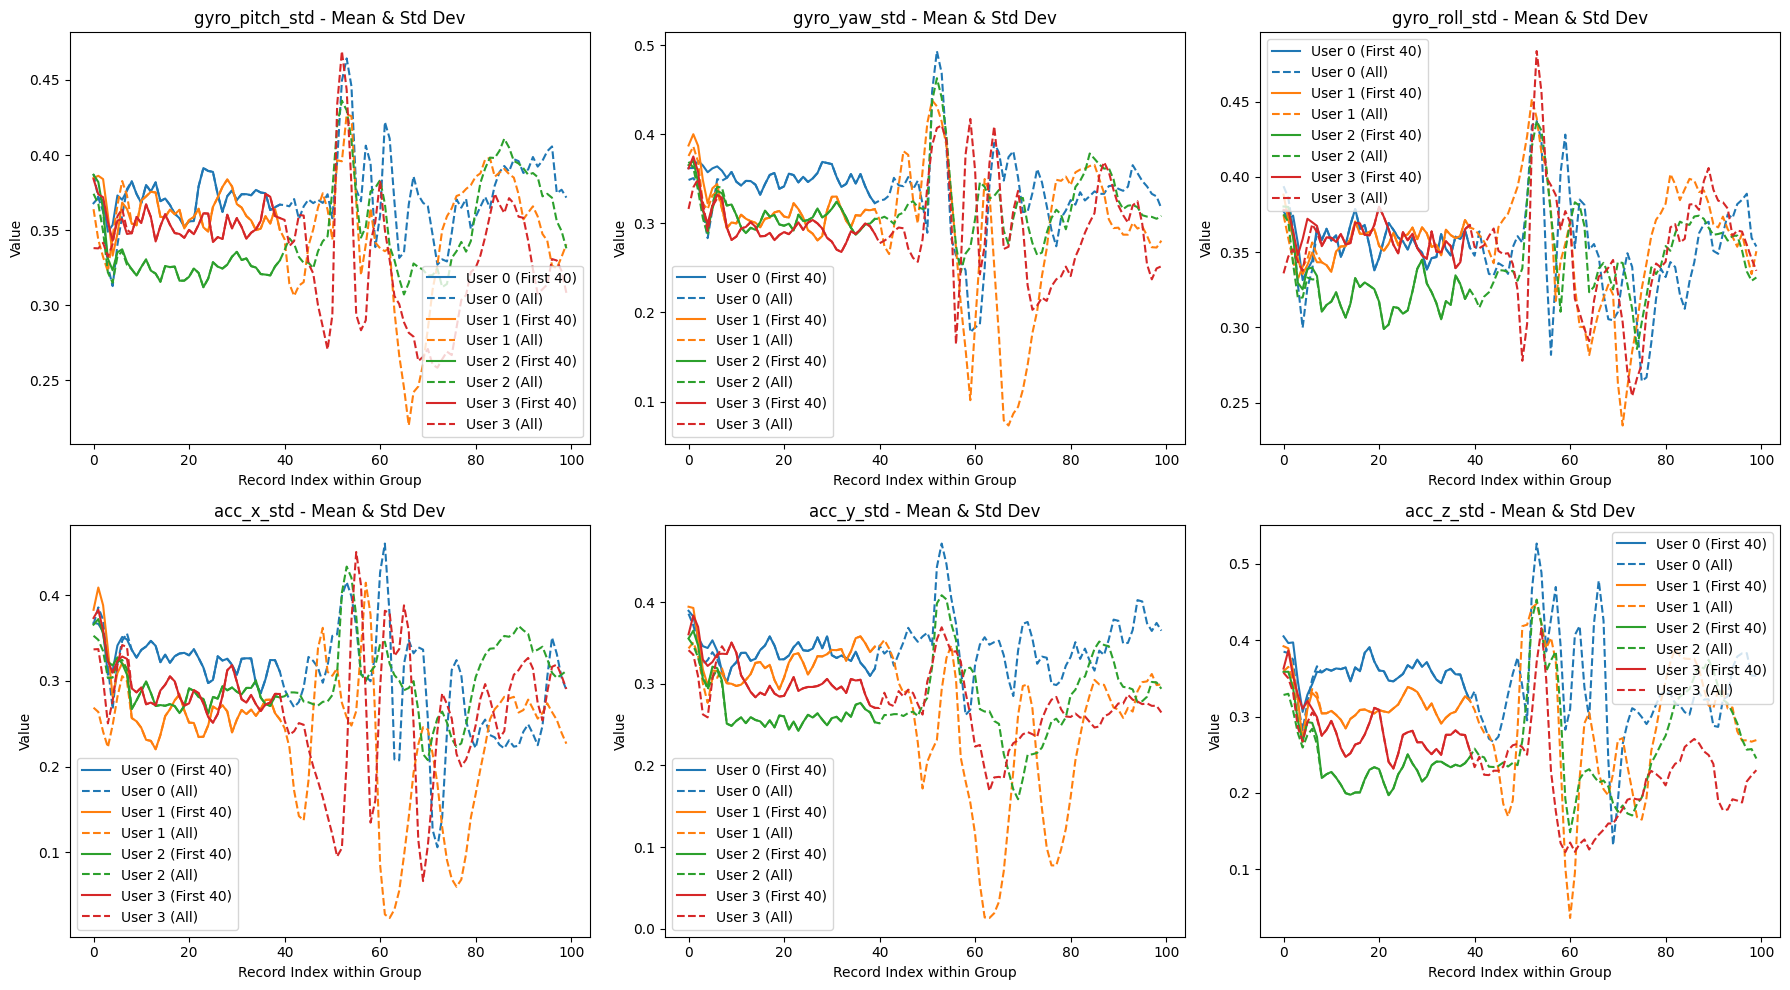

In [4]:
plot_std_variance_filled(df_users_list)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def rolling_min_max_norm(series):
    return (series - series.rolling(window=5, min_periods=1).min()) / \
           (series.rolling(window=5, min_periods=1).max() - series.rolling(window=5, min_periods=1).min() + 1e-9)

def compute_metrics(y_true, y_pred, y_scores):
    """Compute Precision, Recall, F1-Score, Confusion Matrix, and Precision-Recall AUC."""
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Precision-Recall AUC
    pr_auc = average_precision_score(y_true, y_scores)
    
    # Print Metrics
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    
    return precision, recall, f1, cm, pr_auc

def process_and_train_svm(df_list):
    metrics_list = []
    
    for user_idx, df in enumerate(df_list):
        # Step 1: Extract first 40 records per group
        df = df.groupby('group_index').head(40)

        # Step 2: Normalize gyro and accelerometer data
        gyro_acc_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
        df[gyro_acc_cols] = df[gyro_acc_cols].apply(rolling_min_max_norm)

        # Step 3: Convert each group into a 6x40 matrix
        group_matrices = []
        group_labels = []

        for group, group_data in df.groupby('group_index'):
            if len(group_data) == 40:  # Ensure exactly 40 records per group
                matrix = group_data[gyro_acc_cols].values.T  # Shape (6,40)
                group_matrices.append(matrix)
                group_labels.append(1)  # All data is normal (label=1)

        group_matrices = np.array(group_matrices)  # Shape (num_groups, 6, 40)
        group_labels = np.array(group_labels)

        # Step 4: Train-Test Split (80% Train, 20% Test)
        X_train, X_test, y_train, y_test = train_test_split(group_matrices, group_labels, test_size=0.2, random_state=42)

        # Flatten the 6x40 matrix to a single vector (240 features) for SVM
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)

        # Step 5: Train One-Class SVM
        oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
        oc_svm.fit(X_train_flat)

        # Step 6: Evaluate on test set
        y_scores = oc_svm.decision_function(X_test_flat)
        
        # Predict Normal 1, annomal 0
        y_pred = (y_scores >= 0).astype(int)  # Normal (1), Anomaly (0)

        # Step 7: Compute Metrics
        precision, recall, f1, cm, pr_auc = compute_metrics(y_test, y_pred, y_scores)

        # Store results
        metrics_list.append({
            'User ID': user_idx,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Confusion Matrix': cm,
            'Precision-Recall AUC': pr_auc
        })

    # Convert metrics into a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Print metrics table
    print(metrics_df)

    return metrics_df


In [48]:
# the first 40 records 
process_and_train_svm(df_users_list)

C:\Users\lycaz\AppData\Local\Temp\ipykernel_26716\3330112065.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[gyro_acc_cols] = df[gyro_acc_cols].apply(rolling_min_max_norm)
C:\Users\lycaz\AppData\Local\Temp\ipykernel_26716\3330112065.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[gyro_acc_cols] = df[gyro_acc_cols].apply(rolling_min_max_norm)
C:\Users\lycaz\AppData\Local\Temp\ipykernel_26716\3330112065.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Confusion Matrix:
[[ 0  0]
 [19  2]]
Precision: 1.0000
Recall: 0.0952
F1-Score: 0.1739
Precision-Recall AUC: 1.0000
Confusion Matrix:
[[ 0  0]
 [30  5]]
Precision: 1.0000
Recall: 0.1429
F1-Score: 0.2500
Precision-Recall AUC: 1.0000
Confusion Matrix:
[[ 0  0]
 [28 21]]
Precision: 1.0000
Recall: 0.4286
F1-Score: 0.6000
Precision-Recall AUC: 1.0000
Confusion Matrix:
[[ 0  0]
 [27  3]]
Precision: 1.0000
Recall: 0.1000
F1-Score: 0.1818
Precision-Recall AUC: 1.0000
   User ID  Precision    Recall  F1-Score    Confusion Matrix  \
0        0        1.0  0.095238  0.173913   [[0, 0], [19, 2]]   
1        1        1.0  0.142857  0.250000   [[0, 0], [30, 5]]   
2        2        1.0  0.428571  0.600000  [[0, 0], [28, 21]]   
3        3        1.0  0.100000  0.181818   [[0, 0], [27, 3]]   

   Precision-Recall AUC  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  


C:\Users\lycaz\AppData\Local\Temp\ipykernel_26716\3330112065.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[gyro_acc_cols] = df[gyro_acc_cols].apply(rolling_min_max_norm)


User ID  Precision    Recall  F1-Score    Confusion Matrix  \
0        0        1.0  0.095238  0.173913   [[0, 0], [19, 2]]   
1        1        1.0  0.142857  0.250000   [[0, 0], [30, 5]]   
2        2        1.0  0.428571  0.600000  [[0, 0], [28, 21]]   
3        3        1.0  0.100000  0.181818   [[0, 0], [27, 3]]   

   Precision-Recall AUC  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def rolling_min_max_norm(series):
    return (series - series.rolling(window=5, min_periods=1).min()) / \
           (series.rolling(window=5, min_periods=1).max() - series.rolling(window=5, min_periods=1).min() + 1e-9)

def compute_metrics(y_true, y_pred, y_scores):
    """Compute Precision, Recall, F1-Score, Confusion Matrix, and Precision-Recall AUC."""
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_scores)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    
    return precision, recall, f1, cm, pr_auc

def process_and_train_svm_all(df_list):
    metrics_list = []
    
    for user_idx, df in enumerate(df_list):
        all_group_matrices = []
        all_group_labels = []
        
        # Normalize gyro and accelerometer data
        gyro_acc_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
        df[gyro_acc_cols] = df[gyro_acc_cols].apply(rolling_min_max_norm)
        
        # Convert each group into a 6xN matrix
        for group, group_data in df.groupby('group_index'):
            matrix = group_data[gyro_acc_cols].values.T  # Shape (6, N)
            all_group_matrices.append(matrix)
            all_group_labels.append(1)  # All data is normal (label=1)
    
        all_group_matrices = np.array(all_group_matrices)  # Shape (num_groups, 6, N)
        all_group_labels = np.array(all_group_labels)
        
        # Train-Test Split (80% Train, 20% Test)
        X_train, X_test, y_train, y_test = train_test_split(all_group_matrices, all_group_labels, test_size=0.2, random_state=42)
        
        # Flatten the matrix for SVM (6xN -> single vector)
        X_train_flat = np.array([x.flatten() for x in X_train])
        X_test_flat = np.array([x.flatten() for x in X_test])
        
        # Train One-Class SVM for each user
        oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
        oc_svm.fit(X_train_flat)
        
        # Evaluate on test set
        y_scores = oc_svm.decision_function(X_test_flat)
        y_pred = (y_scores >= 0).astype(int)  # Normal (1), Anomaly (0)
        
        # Compute Metrics
        precision, recall, f1, cm, pr_auc = compute_metrics(y_test, y_pred, y_scores)
        
        # Store results
        metrics_list.append({
            'User ID': user_idx,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Confusion Matrix': cm,
            'Precision-Recall AUC': pr_auc
        })
    
    # Convert metrics into a DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    print(metrics_df)
    
    return metrics_df

In [12]:
process_and_train_svm_all(df_users_list)

Confusion Matrix:
[[ 0  0]
 [20  1]]
Precision: 1.0000
Recall: 0.0476
F1-Score: 0.0909
Precision-Recall AUC: 1.0000
Confusion Matrix:
[[ 0  0]
 [25 10]]
Precision: 1.0000
Recall: 0.2857
F1-Score: 0.4444
Precision-Recall AUC: 1.0000
Confusion Matrix:
[[ 0  0]
 [40  9]]
Precision: 1.0000
Recall: 0.1837
F1-Score: 0.3103
Precision-Recall AUC: 1.0000
Confusion Matrix:
[[ 0  0]
 [24  6]]
Precision: 1.0000
Recall: 0.2000
F1-Score: 0.3333
Precision-Recall AUC: 1.0000
   User ID  Precision    Recall  F1-Score    Confusion Matrix  \
0        0        1.0  0.047619  0.090909   [[0, 0], [20, 1]]   
1        1        1.0  0.285714  0.444444  [[0, 0], [25, 10]]   
2        2        1.0  0.183673  0.310345   [[0, 0], [40, 9]]   
3        3        1.0  0.200000  0.333333   [[0, 0], [24, 6]]   

   Precision-Recall AUC  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  


User ID  Precision    Recall  F1-Score    Confusion Matrix  \
0        0        1.0  0.047619  0.090909   [[0, 0], [20, 1]]   
1        1        1.0  0.285714  0.444444  [[0, 0], [25, 10]]   
2        2        1.0  0.183673  0.310345   [[0, 0], [40, 9]]   
3        3        1.0  0.200000  0.333333   [[0, 0], [24, 6]]   

   Precision-Recall AUC  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0

#### 1.3.2  Compare the saperate and non-separete

#### 1.3.2 PCA

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting


def apply_pca_and_plot(df, n_components=3, window_size=5, polyorder=2):
    """
    Applies PCA on the inertial sensor data, including temporal dynamics features,
    and plots the transformed components.

    Parameters:
        df: DataFrame containing inertial sensor data with 'group_index', 'user_id', and 'timestamp'.
        n_components: Number of principal components to retain (default: 3).
        window_size: Window size for Savitzky-Golay filter (must be odd).
        polyorder: Polynomial order for Savitzky-Golay filter.

    Returns:
        Transformed PCA DataFrame.
    """

    # --- 1. Input Validation ---
    if 'group_index' not in df.columns or 'user_id' not in df.columns or 'timestamp' not in df.columns:
        raise ValueError("DataFrame must contain 'group_index', 'user_id', and 'timestamp' columns.")

    features = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in features:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    if window_size % 2 == 0:
        raise ValueError("window_size must be an odd integer.")
    if window_size <= polyorder:
        raise ValueError("window_size must be greater than polyorder.")

    # --- 2. Data Preprocessing and Feature Engineering ---

    # 2.1 Relative Timestamps (within each group and user)
    df = df.sort_values(by=['user_id', 'group_index', 'timestamp'])  # Ensure correct order
    
    # Convert timestamp to datetime if it's a string
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Calculate relative time in seconds within each group
    df['time_relative'] = df.groupby(['user_id', 'group_index'])['timestamp'].transform(
        lambda x: (x - x.min()).dt.total_seconds() if hasattr(x, 'dt') else (x - x.min())
    )

    # 2.2 Feature Engineering: Derivatives (using Savitzky-Golay)
    df_features = df.copy()  # Work on a copy to avoid SettingWithCopyWarning

    for col in features:
        df_features[f'{col}_diff'] = df_features.groupby(['user_id', 'group_index'])[col].transform(
            lambda x: savgol_filter(x, window_length=window_size, polyorder=polyorder, deriv=1)
        ).fillna(0)  # Fill NaNs introduced by the derivative
        
        # Add rolling window statistics
        df_features[f'{col}_mean_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).mean().reset_index(drop=True)
        df_features[f'{col}_std_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).std().reset_index(drop=True)
        df_features.fillna(0, inplace=True) #fill nan after rolling
    
    # 2.3  Define Features for PCA (Include derivatives and rolling stats)
    pca_features = features + [f'{col}_diff' for col in features] + [f'{col}_mean_{window_size}' for col in features] + [f'{col}_std_{window_size}' for col in features] #+ ['time_relative'] # I decide do not add it
   
    # 2.4  Standardization (within each group, IMPORTANT for PCA)
    #       We standardize *before* creating interaction terms.
    for group in df_features['group_index'].unique():
        group_indices = df_features['group_index'] == group
        scaler = StandardScaler()
        # Fix for FutureWarning: Convert to float64 before applying StandardScaler
        group_data = df_features.loc[group_indices, pca_features].astype('float64')
        scaled_data = scaler.fit_transform(group_data)
        
        # Fix for dtype incompatibility warning - explicitly convert to float64 before assignment
        for i, col in enumerate(pca_features):
            df_features.loc[group_indices, col] = scaled_data[:, i].astype('float64')

    # --- 3. PCA ---

    # 3.1 Apply PCA
    X = df_features[pca_features].values
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # 3.2 Create PCA DataFrame
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['group_index'] = df_features['group_index'].values  # Keep group labels

    # --- 4. Plotting ---

    # 4.1  Plot PCA Results
    plt.figure(figsize=(10, 6))

    if n_components == 2:
        scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['group_index'], cmap='viridis', alpha=0.7)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(scatter, label='Group Index')

    elif n_components == 3:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['group_index'], cmap='viridis', alpha=0.7)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        fig.colorbar(scatter, label='Group Index')

    else:
        print("Plotting only supported for 2 or 3 components.")

    plt.title(f'PCA Visualization ({n_components} Components)')
    plt.show()

    return pca_df

/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_62505/902189282.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.51542648  0.46944731  0.66869037  0.46944731  0.6303744   0.41580494
  0.6303744   0.96755496  0.92923899  0.80662787  0.6303744   0.57673203
 -0.01333396 -0.08996591 -0.17426105 -0.74900065 -1.2547715  -1.41569859
 -1.89847985 -2.06707014 -2.05940694 -2.15136528 -1.79885832 -1.78353193
 -1.86016388 -2.19734445 -2.28930278  0.27020425  2.40057237  2.69177377
  2.71476335  2.04806541  0.79130148 -0.11295549  0.22422508  0.64570079
  0.97521816  1.25875636  1.09782927  0.99820774 -0.0976291  -1.09384441
 -1.20112914 -1.22411872 -1.56129929 -1.30075067 -0.92525413 -0.62638953
 -0.40415689  0.16291952  1.04418691  0.36982578  0.27020425  1.74920082
  0.49243689  0.08628757 -0.00567076  0.56906884  0.7683119   0.72999593
  0.66102717  0.23955147 -0.18958744 -0.04398674  0.1935723

<Figure size 1000x600 with 0 Axes>

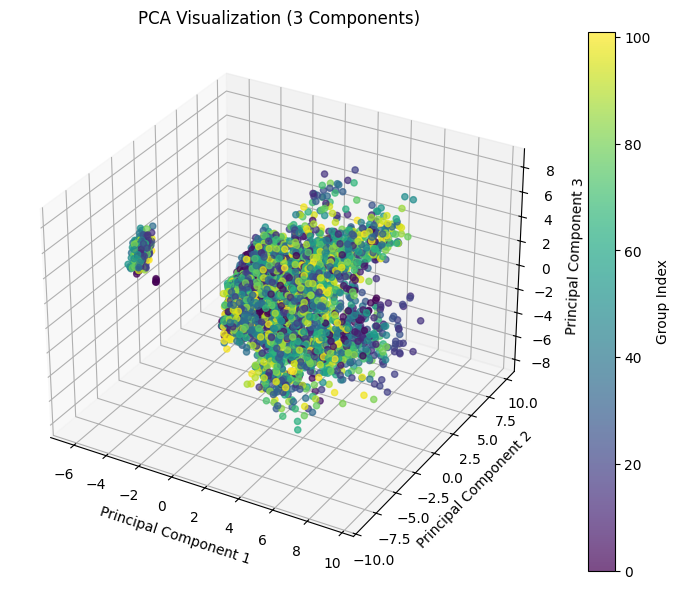

/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_62505/902189282.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.21111234e-02 -1.27455156e-01 -5.74413282e-01 -2.71635196e-01
 -3.00471204e-01 -2.86053200e-01 -8.42011437e-02 -2.28381184e-01
  4.55608928e-02  7.23207083e-01  2.47412950e-01  2.30688065e-03
 -1.56291164e-01  7.43969009e-02  2.90666962e-01  2.61830954e-01
  1.60904925e-01  1.60904925e-01  2.04158937e-01  6.65535067e-01
 -6.97831396e-02  3.11428888e-02 -2.42799188e-01  2.04158937e-01
  2.04158937e-01 -1.27455156e-01 -9.86191477e-02 -2.57217192e-01
  5.99788969e-02 -2.65291275e-02 -9.86191477e-02  1.17650913e-01
  1.46486921e-01 -1.41873160e-01  4.55608928e-02  2.04158937e-01
  4.06010994e-01  3.05084966e-01  3.11428888e-02  8.88149050e-02
  3.11428888e-02 -8.42011437e-02 -1.99545176e-01 -8.42011437e-02
 -5.74413282e-01  1.03232909e-01 -5.45577273e-01 -1.52600155e+00
 -1.39623

<Figure size 1000x600 with 0 Axes>

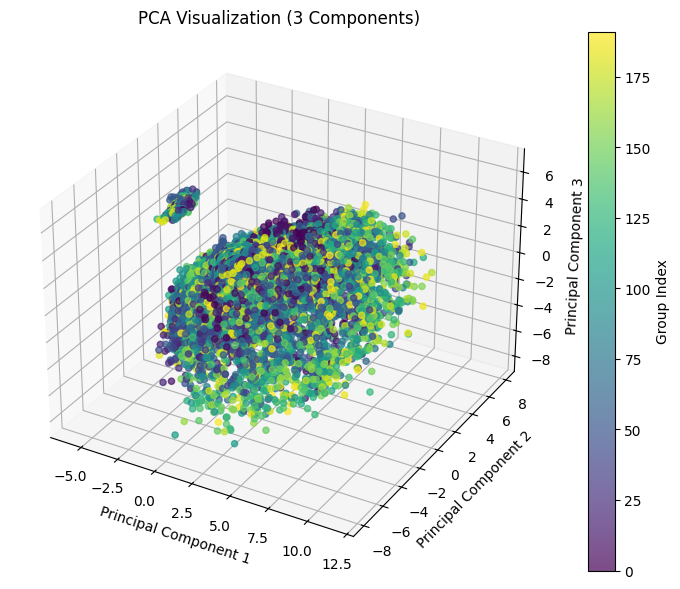

PC1       PC2       PC3  group_index
0     -2.525047 -2.710716  5.305739            0
1     -2.353556 -2.769522  5.410952            0
2     -2.208264 -2.913783  5.488486            0
3     -2.129333 -2.835338  5.564304            0
4     -0.763396 -0.404680  1.241522            0
...         ...       ...       ...          ...
17495 -1.129494 -0.121258  1.075786          191
17496 -0.902411 -0.213221  0.923023          191
17497 -0.926965 -0.049125  0.958815          191
17498 -0.716855  0.166597  1.149892          191
17499 -0.493993  0.531583  1.150840          191

[17500 rows x 4 columns]

In [85]:
apply_pca_and_plot(crs_df)
apply_pca_and_plot(df_user2)

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D


def compare_pca_users(df1, df2, n_components=3, window_size=5, polyorder=2):
    """
    Compares the PCA results of two user DataFrames.

    Parameters:
        df1: DataFrame for the first user (must contain 'group_index', 'user_id', 'timestamp', and sensor data).
        df2: DataFrame for the second user (same format as df1).
        n_components: Number of principal components to retain.
        window_size: Window size for Savitzky-Golay filter.
        polyorder: Polynomial order for Savitzky-Golay filter.

    Returns:
        None (displays a PCA plot comparing the two users).
    """

    # 1. Preprocess and apply PCA to each DataFrame *separately*
    pca_df1 = apply_pca_preprocessing(df1, n_components, window_size, polyorder)
    pca_df2 = apply_pca_preprocessing(df2, n_components, window_size, polyorder)

    # Add a user identifier to each PCA DataFrame
    pca_df1['user'] = 'User 1'  # Assuming df1 is from User 1
    pca_df2['user'] = 'User 2'  # Assuming df2 is from User 2
    # Ensure user_id is present for plotting. If it's constant within each df, this is fine.
    pca_df1['user_id'] = df1['user_id'].iloc[0]  # Take the first user_id
    pca_df2['user_id'] = df2['user_id'].iloc[0]  # Take the first user_id

    # 2. Combine the PCA DataFrames
    combined_pca_df = pd.concat([pca_df1, pca_df2], ignore_index=True)

    # 3. Plot the combined PCA results
    plt.figure(figsize=(12, 8))

    if n_components == 2:
        for user in combined_pca_df['user'].unique():
            user_data = combined_pca_df[combined_pca_df['user'] == user]
            plt.scatter(user_data['PC1'], user_data['PC2'], label=f'{user} (ID: {user_data["user_id"].iloc[0]})', alpha=0.7)

        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('PCA Comparison of Two Users (2D)')
        plt.legend()

    elif n_components == 3:
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        for user in combined_pca_df['user'].unique():
            user_data = combined_pca_df[combined_pca_df['user'] == user]
            ax.scatter(user_data['PC1'], user_data['PC2'], user_data['PC3'], label=f'{user} (ID: {user_data["user_id"].iloc[0]})', alpha=0.7)

        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title('PCA Comparison of Two Users (3D)')
        ax.legend()
    else:
        print("Plotting only supported for 2 or 3 components.")
    plt.show()


def apply_pca_preprocessing(df, n_components=3, window_size=5, polyorder=2):
    """
    Applies PCA preprocessing and returns the PCA DataFrame.  This is now a
    separate function to avoid code duplication.
    """
    # --- 1. Input Validation ---
    if 'group_index' not in df.columns or 'user_id' not in df.columns or 'timestamp' not in df.columns:
        raise ValueError("DataFrame must contain 'group_index', 'user_id', and 'timestamp' columns.")

    features = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in features:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    if window_size % 2 == 0:
        raise ValueError("window_size must be an odd integer.")
    if window_size <= polyorder:
        raise ValueError("window_size must be greater than polyorder.")

    # --- 2. Data Preprocessing and Feature Engineering ---
    df = df.sort_values(by=['user_id', 'group_index', 'timestamp'])
     # Convert timestamp to datetime if it's a string
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Calculate relative time in seconds within each group
    df['time_relative'] = df.groupby(['user_id', 'group_index'])['timestamp'].transform(
        lambda x: (x - x.min()).dt.total_seconds() if hasattr(x, 'dt') else (x - x.min())
    )


    df_features = df.copy()

    for col in features:
        df_features[f'{col}_diff'] = df_features.groupby(['user_id', 'group_index'])[col].transform(
            lambda x: savgol_filter(x, window_length=window_size, polyorder=polyorder, deriv=1)
        ).fillna(0)
        df_features[f'{col}_mean_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).mean().reset_index(drop=True)
        df_features[f'{col}_std_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).std().reset_index(drop=True)
        df_features.fillna(0, inplace=True)

    pca_features = features + [f'{col}_diff' for col in features] + [f'{col}_mean_{window_size}' for col in features] + [f'{col}_std_{window_size}' for col in features]

    # --- Standardization (within each group) ---
    for group in df_features['group_index'].unique():
        group_indices = df_features['group_index'] == group
        scaler = StandardScaler()
         # Fix for FutureWarning: Convert to float64 before applying StandardScaler
        group_data = df_features.loc[group_indices, pca_features].astype('float64')
        scaled_data = scaler.fit_transform(group_data)
        
        # Fix for dtype incompatibility warning - explicitly convert to float64 before assignment
        for i, col in enumerate(pca_features):
            df_features.loc[group_indices, col] = scaled_data[:, i].astype('float64')

    # --- PCA ---
    X = df_features[pca_features].values
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['group_index'] = df_features['group_index'].values # Keep group labels.
    return pca_df

/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_62505/2731560722.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.51542648  0.46944731  0.66869037  0.46944731  0.6303744   0.41580494
  0.6303744   0.96755496  0.92923899  0.80662787  0.6303744   0.57673203
 -0.01333396 -0.08996591 -0.17426105 -0.74900065 -1.2547715  -1.41569859
 -1.89847985 -2.06707014 -2.05940694 -2.15136528 -1.79885832 -1.78353193
 -1.86016388 -2.19734445 -2.28930278  0.27020425  2.40057237  2.69177377
  2.71476335  2.04806541  0.79130148 -0.11295549  0.22422508  0.64570079
  0.97521816  1.25875636  1.09782927  0.99820774 -0.0976291  -1.09384441
 -1.20112914 -1.22411872 -1.56129929 -1.30075067 -0.92525413 -0.62638953
 -0.40415689  0.16291952  1.04418691  0.36982578  0.27020425  1.74920082
  0.49243689  0.08628757 -0.00567076  0.56906884  0.7683119   0.72999593
  0.66102717  0.23955147 -0.18958744 -0.04398674  0.19357

<Figure size 1200x800 with 0 Axes>

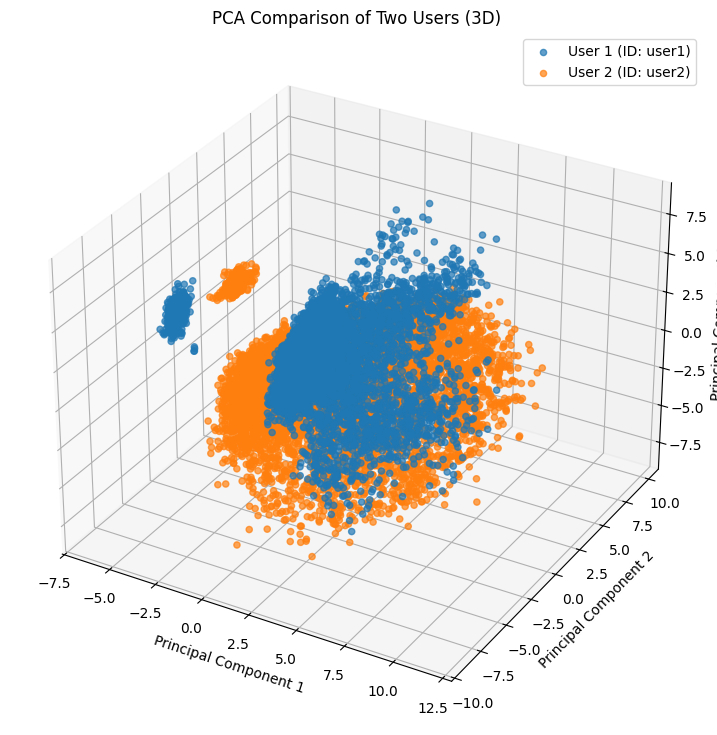

In [87]:
compare_pca_users(df_user1,df_user2)

In [26]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.fft import fft

def compare_pca_multiple_users(dfs, n_components=3, window_size=5, polyorder=2):
    all_pca_dfs_full = []
    all_pca_dfs_reduced = []
    all_pca_dfs_avg = []  # For storing user averages
    
    for i, df in enumerate(dfs):
        filtered_df = df.groupby("group_index").apply(lambda x: x.iloc[40:80] if len(x) >= 80 else None).reset_index(drop=True)
        filtered_df = filtered_df.dropna()
        
        pca_df_full = apply_pca_preprocessing(filtered_df, n_components, window_size, polyorder, reduced=False)
        pca_df_full['user'] = f'User {i+1}'
        pca_df_full['user_id'] = df['user_id'].iloc[0]
        all_pca_dfs_full.append(pca_df_full)
        
        pca_df_reduced = apply_pca_preprocessing(filtered_df, n_components, window_size, polyorder, reduced=True)
        pca_df_reduced['user'] = f'User {i+1}'
        pca_df_reduced['user_id'] = df['user_id'].iloc[0]
        all_pca_dfs_reduced.append(pca_df_reduced)
        
        # Calculate average PCA values for each user across all their groups
        avg_pca = pca_df_full.groupby('user')[['PC1', 'PC2', 'PC3'][:n_components]].mean().reset_index()
        avg_pca['user_id'] = df['user_id'].iloc[0]
        all_pca_dfs_avg.append(avg_pca)
    
    combined_pca_df_full = pd.concat(all_pca_dfs_full, ignore_index=True)
    combined_pca_df_reduced = pd.concat(all_pca_dfs_reduced, ignore_index=True)
    combined_pca_df_avg = pd.concat(all_pca_dfs_avg, ignore_index=True)
    
    plot_pca(combined_pca_df_full, n_components, title="PCA with Full Feature Set")
    plot_pca(combined_pca_df_reduced, n_components, title="PCA with Reduced Feature Set + Higher-Order Derivatives")
    plot_pca_averages(combined_pca_df_avg, n_components, title="Average PCA Values Across Groups (Per User)")

def apply_pca_preprocessing(df, n_components=3, window_size=5, polyorder=2, reduced=False):
    base_features = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    df = df.sort_values(by=['user_id', 'group_index', 'timestamp'])
    
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    df['time_relative'] = df.groupby(['user_id', 'group_index'])['timestamp'].transform(lambda x: (x - x.min()).dt.total_seconds())
    df_features = df.copy()
    
    for col in base_features:
        # First-order derivatives and basic statistics
        df_features[f'{col}_diff'] = df_features.groupby(['user_id', 'group_index'])[col].transform(lambda x: savgol_filter(x, window_length=window_size, polyorder=polyorder, deriv=1)).fillna(0)
        df_features[f'{col}_mean_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).mean().reset_index(drop=True)
        df_features[f'{col}_std_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).std().reset_index(drop=True)
        df_features[f'{col}_2nd_diff'] = df_features.groupby(['user_id', 'group_index'])[col].transform(lambda x: savgol_filter(x, window_length=window_size, polyorder=polyorder, deriv=2)).fillna(0)
        df_features[f'{col}_3rd_diff'] = df_features.groupby(['user_id', 'group_index'])[col].transform(lambda x: savgol_filter(x, window_length=window_size, polyorder=polyorder, deriv=3)).fillna(0)
        
        # Additional statistical features
        df_features[f'{col}_skew_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).apply(lambda x: stats.skew(x) if len(x) > 2 else 0).reset_index(drop=True)
        df_features[f'{col}_kurt_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).apply(lambda x: stats.kurtosis(x) if len(x) > 2 else 0).reset_index(drop=True)
        df_features[f'{col}_q25_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).apply(lambda x: np.percentile(x, 25) if len(x) > 0 else 0).reset_index(drop=True)
        df_features[f'{col}_q75_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).apply(lambda x: np.percentile(x, 75) if len(x) > 0 else 0).reset_index(drop=True)
        
        # FFT-based features - Fix for TypeError by handling each group separately
        fft_max_values = []
        total_power_values = []
        
        for (user_id, group_idx), group_data in df_features.groupby(['user_id', 'group_index']):
            series = group_data[col].values
            window_len = window_size * 2
            
            # Initialize with zeros
            group_fft_max = np.zeros(len(group_data))
            group_total_power = np.zeros(len(group_data))
            
            # Calculate FFT features for each window in the group
            for i in range(len(series) - window_len + 1):
                window = series[i:i+window_len]
                if len(window) >= 2:  # Ensure we have enough data
                    fft_vals = np.abs(fft(window))
                    if len(fft_vals) > 1:
                        group_fft_max[i+window_len-1] = np.max(fft_vals[1:])
                        group_total_power[i+window_len-1] = np.sum(fft_vals[1:]**2)
            
            fft_max_values.append(pd.Series(group_fft_max, index=group_data.index))
            total_power_values.append(pd.Series(group_total_power, index=group_data.index))
        
        # Combine all groups' FFT features
        if fft_max_values:
            df_features[f'{col}_fft_max'] = pd.concat(fft_max_values)
            df_features[f'{col}_total_power'] = pd.concat(total_power_values)
    
    df_features.fillna(0, inplace=True)
    
    if reduced:
        # Include all the new features in the reduced feature set
        pca_features = [
            f'{col}_diff' for col in base_features
        ] + [
            f'{col}_mean_{window_size}' for col in base_features
        ] + [
            f'{col}_std_{window_size}' for col in base_features
        ] + [
            f'{col}_2nd_diff' for col in base_features
        ] + [
            f'{col}_3rd_diff' for col in base_features
        ] + [
            f'{col}_skew_{window_size}' for col in base_features
        ] + [
            f'{col}_kurt_{window_size}' for col in base_features
        ] + [
            f'{col}_q25_{window_size}' for col in base_features
        ] + [
            f'{col}_q75_{window_size}' for col in base_features
        ] + [
            f'{col}_fft_max' for col in base_features if f'{col}_fft_max' in df_features.columns
        ] + [
            f'{col}_total_power' for col in base_features if f'{col}_total_power' in df_features.columns
        ]
    else:
        pca_features = base_features + [f'{col}_diff' for col in base_features] + [f'{col}_mean_{window_size}' for col in base_features] + [f'{col}_std_{window_size}' for col in base_features]
    
    for group in df_features['group_index'].unique():
        group_indices = df_features['group_index'] == group
        scaler = StandardScaler()
        group_data = df_features.loc[group_indices, pca_features].astype('float64')
        scaled_data = scaler.fit_transform(group_data)
        for i, col in enumerate(pca_features):
            df_features.loc[group_indices, col] = scaled_data[:, i].astype('float64')
    
    X = df_features[pca_features].values
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['group_index'] = df_features['group_index'].values
    
    return pca_df

def plot_pca(pca_df, n_components, title="PCA Plot"):
    plt.figure(figsize=(12, 8))
    
    if n_components == 2:
        for user in pca_df['user'].unique():
            user_data = pca_df[pca_df['user'] == user]
            plt.scatter(user_data['PC1'], user_data['PC2'], label=f'{user} (ID: {user_data["user_id"].iloc[0]})', alpha=0.7)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(title)
        plt.legend()
    elif n_components == 3:
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        for user in pca_df['user'].unique():
            user_data = pca_df[pca_df['user'] == user]
            ax.scatter(user_data['PC1'], user_data['PC2'], user_data['PC3'], label=f'{user} (ID: {user_data["user_id"].iloc[0]})', alpha=0.7)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title(title)
        ax.legend()
    else:
        print("Plotting only supported for 2 or 3 components.")
    
    plt.show()

def plot_pca_averages(avg_pca_df, n_components, title="Average PCA Values"):
    plt.figure(figsize=(12, 8))
    
    if n_components == 2:
        plt.scatter(avg_pca_df['PC1'], avg_pca_df['PC2'], s=100, c=range(len(avg_pca_df)), cmap='viridis', marker='*')
        
        # Add user labels
        for i, row in avg_pca_df.iterrows():
            plt.annotate(f"{row['user']} (ID: {row['user_id']})", 
                         (row['PC1'], row['PC2']),
                         xytext=(10, 5),
                         textcoords='offset points',
                         fontsize=12,
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.xlabel('Principal Component 1', fontsize=12)
        plt.ylabel('Principal Component 2', fontsize=12)
        plt.title(title, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
    elif n_components == 3:
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(avg_pca_df['PC1'], avg_pca_df['PC2'], avg_pca_df['PC3'], 
                  s=100, c=range(len(avg_pca_df)), cmap='viridis', marker='*')
        
        # Add user labels
        for i, row in avg_pca_df.iterrows():
            ax.text(row['PC1'], row['PC2'], row['PC3'], 
                   f"{row['user']} (ID: {row['user_id']})",
                   fontsize=10)
        
        ax.set_xlabel('Principal Component 1', fontsize=12)
        ax.set_ylabel('Principal Component 2', fontsize=12)
        ax.set_zlabel('Principal Component 3', fontsize=12)
        ax.set_title(title, fontsize=14)
    else:
        print("Plotting only supported for 2 or 3 components.")
    
    plt.tight_layout()
    plt.show()


In [27]:
df_list=[df_user1,df_user2,df_user3,df_user4]

/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_76397/4084693498.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby("group_index").apply(lambda x: x.iloc[40:80] if len(x) >= 80 else None).reset_index(drop=True)
/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_76397/4084693498.py:62: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_features[f'{col}_skew_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).apply(lambda x: stats.skew(x) if len(x) > 2 else 0).reset_index(drop=True)
/

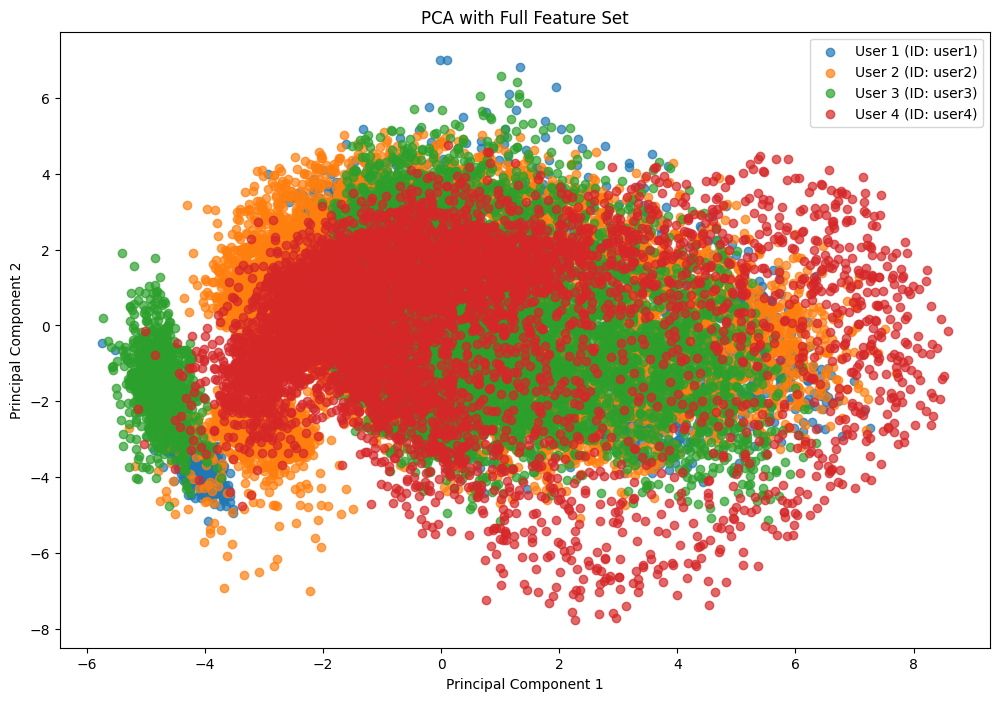

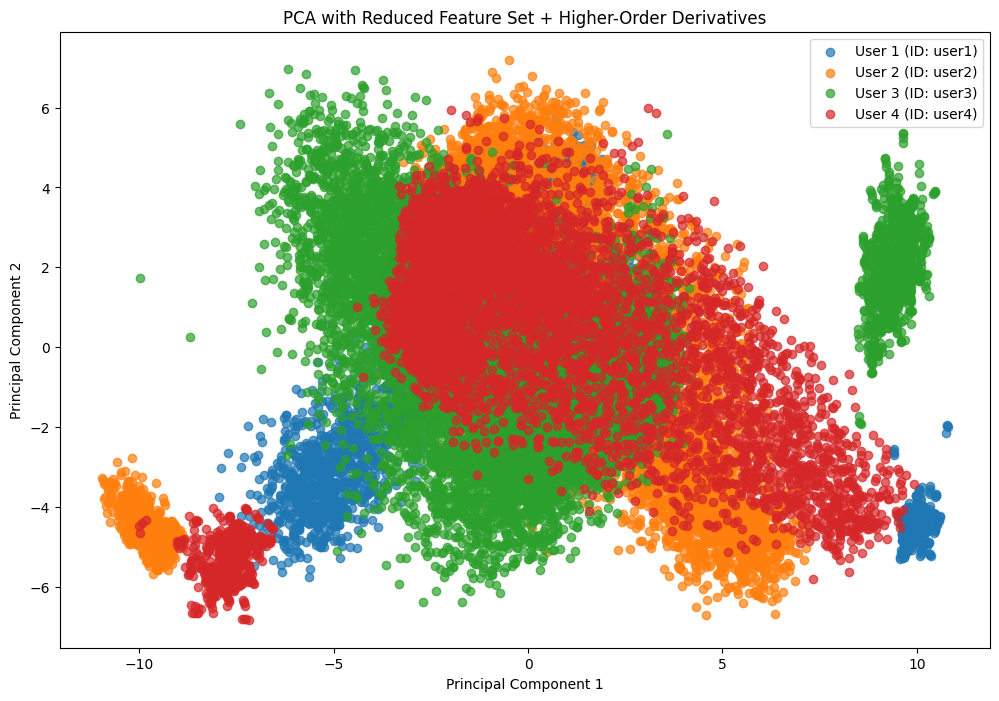

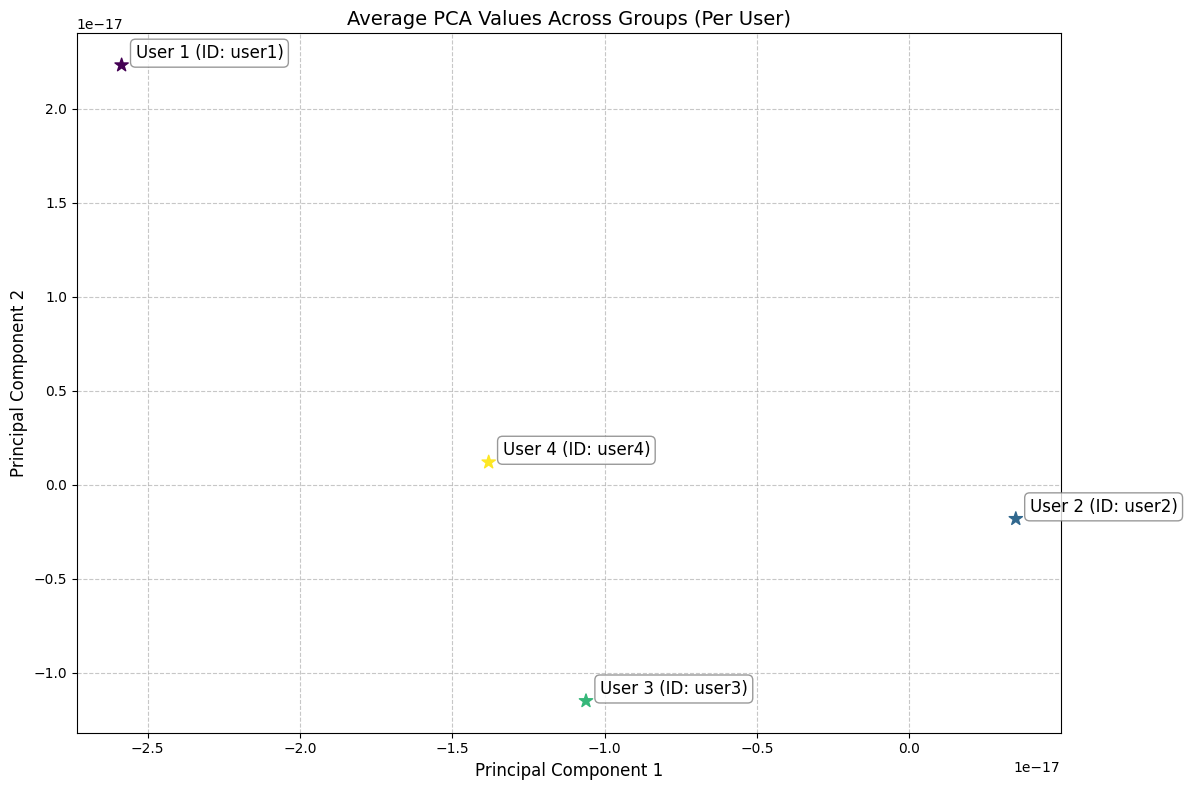

In [28]:
compare_pca_multiple_users(df_list,n_components=2)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.feature_selection import f_classif
from scipy.fft import fft

def anova_feature_selection(dfs, window_size=5, polyorder=2):
    """
    Perform ANOVA F-test to identify the most relevant features associated with user_id.
    
    Args:
        dfs: List of DataFrames containing motion data for different users.
        window_size: Window size for rolling statistics and Savitzky-Golay filter.
        polyorder: Polynomial order for Savitzky-Golay filter.
    
    Returns:
        DataFrame with feature names and their corresponding ANOVA F-scores.
    """
    # Combine all DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Filter to keep only the 40th to 80th records per group
    filtered_df = combined_df.groupby(['user_id', 'group_index']).apply(lambda x: x.iloc[40:80] if len(x) >= 80 else None).reset_index(drop=True)
    filtered_df = filtered_df.dropna(subset=['gyro_pitch'])  # Remove any None groups
    
    # Define all base features
    base_features = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    
    # Compute derived features
    df_features = filtered_df.copy()
    for col in base_features:
        df_features[f'{col}_diff'] = df_features.groupby(['user_id', 'group_index'])[col].transform(lambda x: savgol_filter(x, window_length=window_size, polyorder=polyorder, deriv=1)).fillna(0)
        df_features[f'{col}_mean_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).mean().reset_index(drop=True)
        df_features[f'{col}_std_{window_size}'] = df_features.groupby(['user_id', 'group_index'])[col].rolling(window=window_size).std().reset_index(drop=True)
        df_features[f'{col}_2nd_diff'] = df_features.groupby(['user_id', 'group_index'])[col].transform(lambda x: savgol_filter(x, window_length=window_size, polyorder=polyorder, deriv=2)).fillna(0)
        df_features[f'{col}_3rd_diff'] = df_features.groupby(['user_id', 'group_index'])[col].transform(lambda x: savgol_filter(x, window_length=window_size, polyorder=polyorder, deriv=3)).fillna(0)
        
        # Add FFT-based features
        df_features[f'{col}_fft'] = df_features.groupby(['user_id', 'group_index'])[col].transform(
            lambda x: np.abs(fft(x - np.mean(x)))[1:len(x)//2].mean() if len(x) > 1 else 0
        ).fillna(0)
        
        # Add total power (sum of squared FFT magnitudes)
        df_features[f'{col}_total_power'] = df_features.groupby(['user_id', 'group_index'])[col].transform(
            lambda x: np.sum(np.abs(fft(x - np.mean(x)))[1:len(x)//2]**2) if len(x) > 1 else 0
        ).fillna(0)
        
        # Add spectral centroid (weighted mean of frequencies)
        df_features[f'{col}_spectral_centroid'] = df_features.groupby(['user_id', 'group_index'])[col].transform(
            lambda x: calculate_spectral_centroid(x) if len(x) > 1 else 0
        ).fillna(0)
        
        # Add spectral spread (variance of frequencies around centroid)
        df_features[f'{col}_spectral_spread'] = df_features.groupby(['user_id', 'group_index'])[col].transform(
            lambda x: calculate_spectral_spread(x) if len(x) > 1 else 0
        ).fillna(0)
    
    # Define all feature names
    derived_features = [f'{col}_diff' for col in base_features] + \
                       [f'{col}_2nd_diff' for col in base_features] + \
                       [f'{col}_3rd_diff' for col in base_features] + \
                       [f'{col}_mean_{window_size}' for col in base_features] + \
                       [f'{col}_std_{window_size}' for col in base_features] + \
                       [f'{col}_fft' for col in base_features] + \
                       [f'{col}_total_power' for col in base_features] + \
                       [f'{col}_spectral_centroid' for col in base_features] + \
                       [f'{col}_spectral_spread' for col in base_features]
    
    all_features = base_features + derived_features
    
    # Drop NaN values
    df_features = df_features.dropna(subset=all_features + ['user_id'])
    
    # Extract features and labels
    X = df_features[all_features]
    y = df_features['user_id']
    
    # Perform ANOVA F-test
    f_scores, p_values = f_classif(X, y)
    
    # Create DataFrame with results
    feature_scores = pd.DataFrame({'Feature': all_features, 'F-Score': f_scores})
    feature_scores = feature_scores.sort_values(by='F-Score', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(feature_scores['Feature'], feature_scores['F-Score'], color='skyblue')
    plt.xlabel('F-Score')
    plt.ylabel('Feature')
    plt.title('ANOVA F-Statistic Feature Importance (Records 40-80)')
    plt.gca().invert_yaxis()
    plt.show()
    
    return feature_scores

def calculate_spectral_centroid(x):
    """Calculate the spectral centroid of a signal."""
    x = x - np.mean(x)  # Remove DC component
    X = np.abs(fft(x))
    
    # Use only the first half of the spectrum (excluding DC)
    X = X[1:len(x)//2]
    freqs = np.arange(1, len(x)//2)
    
    # Avoid division by zero
    if np.sum(X) == 0:
        return 0
    
    # Calculate centroid
    return np.sum(freqs * X) / np.sum(X)

def calculate_spectral_spread(x):
    """Calculate the spectral spread (variance) around the centroid."""
    x = x - np.mean(x)  # Remove DC component
    X = np.abs(fft(x))
    
    # Use only the first half of the spectrum (excluding DC)
    X = X[1:len(x)//2]
    freqs = np.arange(1, len(x)//2)
    
    # Avoid division by zero
    if np.sum(X) == 0 or len(freqs) <= 1:
        return 0
    
    # Calculate centroid
    centroid = np.sum(freqs * X) / np.sum(X)
    
    # Calculate spread (variance)
    return np.sqrt(np.sum(((freqs - centroid) ** 2) * X) / np.sum(X))


/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_76397/4261845246.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = combined_df.groupby(['user_id', 'group_index']).apply(lambda x: x.iloc[40:80] if len(x) >= 80 else None).reset_index(drop=True)
/opt/miniconda3/envs/pyds/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [18 19 20 21 22 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/miniconda3/envs/pyds/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


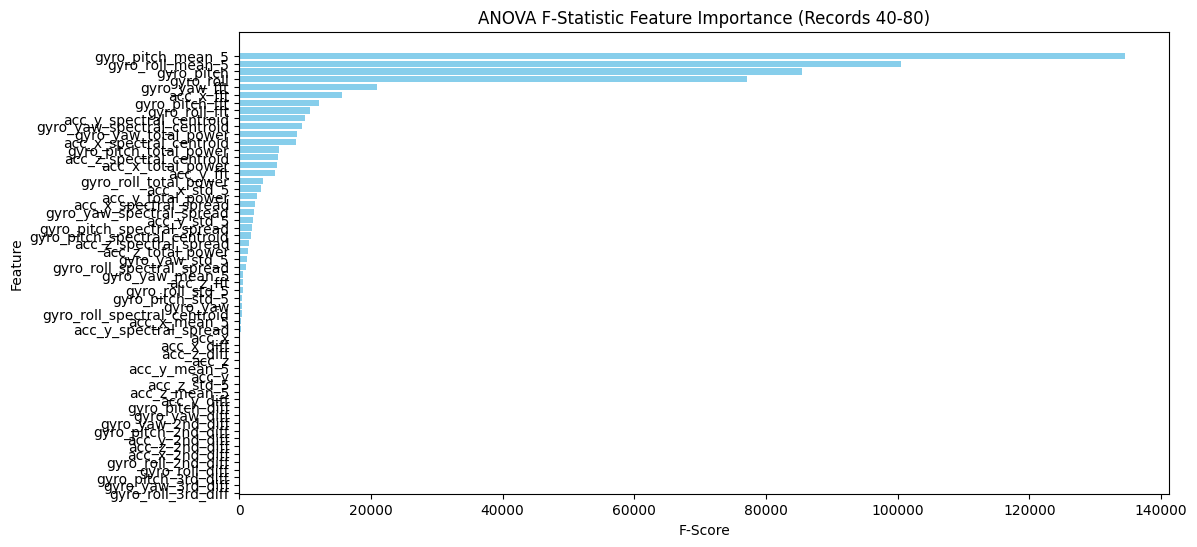

                         Feature        F-Score
24             gyro_pitch_mean_5  134464.135454
26              gyro_roll_mean_5  100472.712009
0                     gyro_pitch   85451.627600
2                      gyro_roll   77175.185435
37                  gyro_yaw_fft   20990.388959
39                     acc_x_fft   15626.318097
36                gyro_pitch_fft   12093.822263
38                 gyro_roll_fft   10708.250120
52       acc_y_spectral_centroid   10028.536000
49    gyro_yaw_spectral_centroid    9560.599851
43          gyro_yaw_total_power    8738.812649
51       acc_x_spectral_centroid    8703.081781
42        gyro_pitch_total_power    6133.404113
53       acc_z_spectral_centroid    5966.497465
45             acc_x_total_power    5825.571687
40                     acc_y_fft    5385.708038
44         gyro_roll_total_power    3659.954481
33                   acc_x_std_5    3353.983209
46             acc_y_total_power    2653.958280
57         acc_x_spectral_spread    2454

In [30]:
anova_results = anova_feature_selection(df_list)
print(anova_results)

### 1.5.3 trajectory

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def reconstruct_and_plot_acc_relationships(df):
    """
    Reconstructs a 2D trajectory (displacement in X and Y) from accelerometer data 
    by double-integrating acceleration using timestamp differences for dt, and
    also creates two additional plots showing:
      - acc_x vs. acc_z
      - acc_y vs. acc_z
      
    Assumes the DataFrame has the following columns:
      - 'group_index'
      - 'timestamp' (in a format parseable by pd.to_datetime)
      - 'acc_x'
      - 'acc_y'
      - 'acc_z'
    
    All plots are rendered in blue with alpha=0.5 and without group labels.
    """
    
    # Check for required columns
    required_cols = ['group_index', 'timestamp', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return
    
    groups = sorted(df['group_index'].unique())
    
    # Create a figure with 3 subplots (vertical layout)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    
    for group in groups:
        # Filter and sort data by timestamp for each group
        group_data = df[df['group_index'] == group].sort_values(by='timestamp')
        
        # Convert timestamps to datetime objects and then to seconds since epoch
        timestamps = pd.to_datetime(group_data['timestamp']).values
        timestamps_seconds = np.array([ts.astype('float64') / 1e9 for ts in timestamps])
        
        # Extract accelerometer data
        acc_x = group_data['acc_x'].values
        acc_y = group_data['acc_y'].values
        acc_z = group_data['acc_z'].values
        
        n = len(timestamps_seconds)
        if n < 2:
            continue  # Not enough data to integrate or plot
        
        # Reconstruct trajectory (double integration for acc_x and acc_y)
        vel_x = np.zeros(n)
        vel_y = np.zeros(n)
        disp_x = np.zeros(n)
        disp_y = np.zeros(n)
        
        for j in range(1, n):
            dt = timestamps_seconds[j] - timestamps_seconds[j-1]  # dt in seconds
            vel_x[j] = vel_x[j-1] + acc_x[j] * dt
            vel_y[j] = vel_y[j-1] + acc_y[j] * dt
            
            disp_x[j] = disp_x[j-1] + vel_x[j] * dt
            disp_y[j] = disp_y[j-1] + vel_y[j] * dt
        
        # Plot the reconstructed trajectory (displacement X vs. displacement Y)
        ax1.plot(disp_x, disp_y, color='blue', alpha=0.5)
        
        # Plot the relationship: acc_x vs. acc_z
        ax2.plot(acc_x, acc_z, color='blue', alpha=0.5)
        
        # Plot the relationship: acc_y vs. acc_z
        ax3.plot(acc_y, acc_z, color='blue', alpha=0.5)
    
    # Set labels and titles for the subplots
    ax1.set_xlabel('Displacement X')
    ax1.set_ylabel('Displacement Y')
    ax1.set_title('Reconstructed 2D Trajectories')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)

    
    ax2.set_xlabel('acc_x')
    ax2.set_ylabel('acc_z')
    ax2.set_title('Relationship: acc_x vs. acc_z')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    ax3.set_xlabel('acc_y')
    ax3.set_ylabel('acc_z')
    ax3.set_title('Relationship: acc_y vs. acc_z')
    ax3.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()




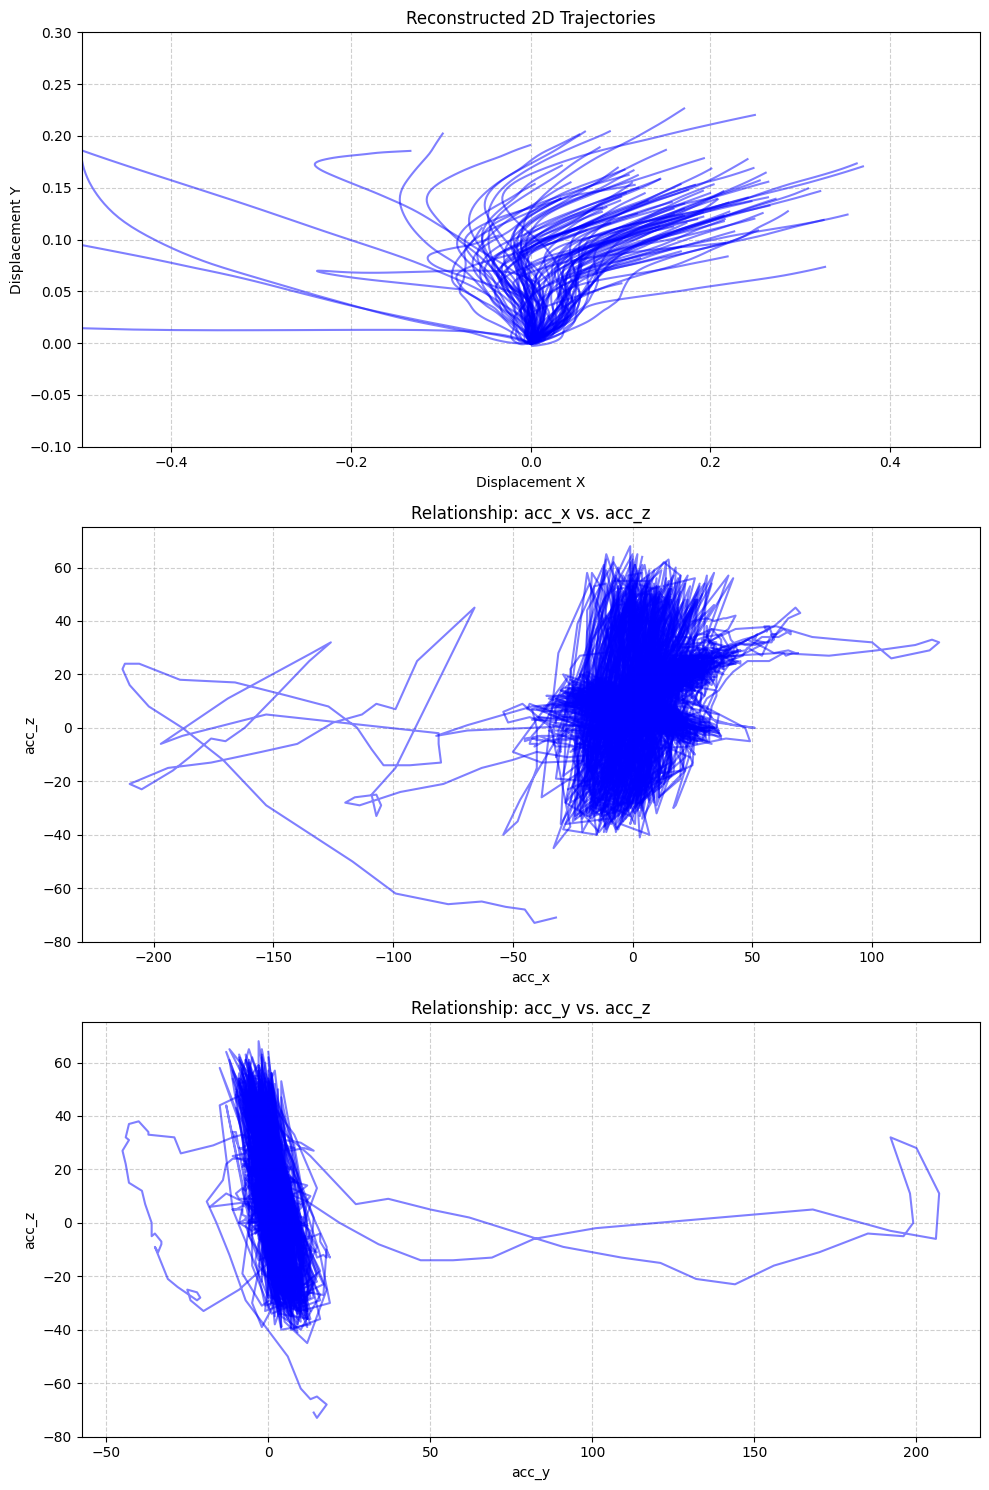

In [117]:
reconstruct_and_plot_acc_relationships(crs_df)

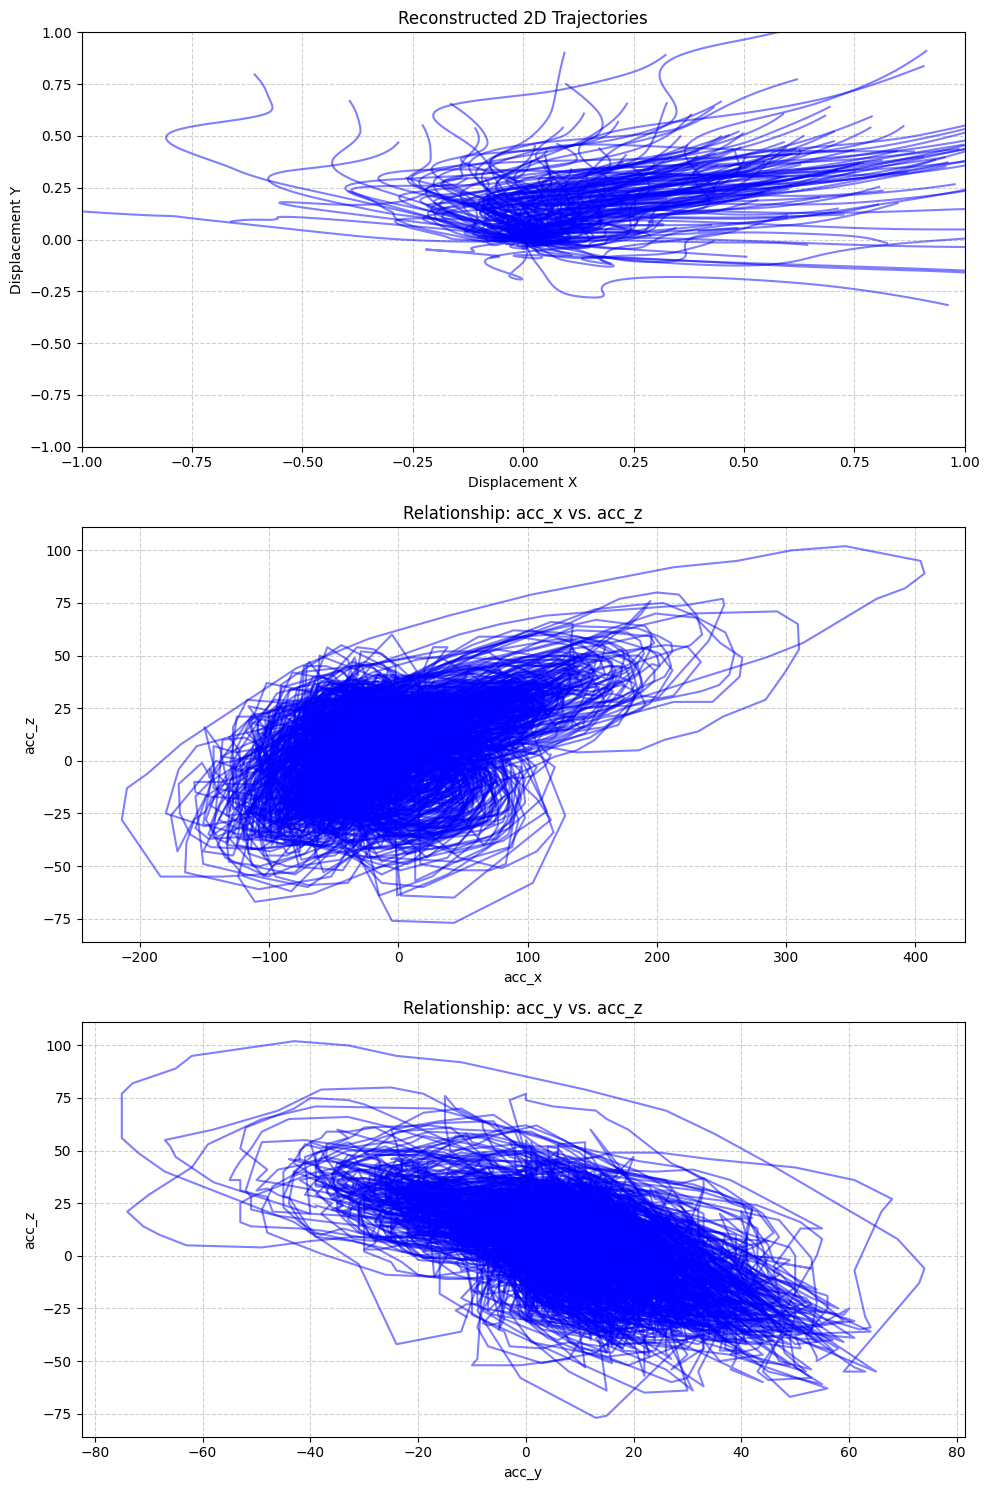

In [69]:
reconstruct_and_plot_acc_relationships(df_user2)

## 2.Baseline model 
- LSTM RNN (Autoencoder)
    - None Seprate
    - None haptic 
    - Raw data
    - Normalize( min-max ,win5)

In [23]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")



PyTorch version: 2.6.0+cpu
CUDA available: False
CUDA device: None


In [53]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error
import time

# Helper function to apply sliding window min-max normalization on a 2D array
def sliding_window_minmax_normalize(arr, window_size=5):
    """
    Normalizes each row of arr using the min and max computed from a sliding window.
    arr: numpy array of shape (N, num_features)
    window_size: size of the sliding window (e.g., 5)
    Returns:
        normalized_arr: numpy array of shape (N, num_features)
    """
    N, d = arr.shape
    normalized_arr = np.zeros_like(arr)
    half_window = window_size // 2
    for i in range(N):
        start = max(0, i - half_window)
        end = min(N, i + half_window + 1)
        window = arr[start:end, :]
        window_min = window.min(axis=0)
        window_max = window.max(axis=0)
        # Add a small constant to avoid division by zero
        normalized_arr[i, :] = (arr[i, :] - window_min) / (window_max - window_min + 1e-8)
    return normalized_arr

def sliding_window_standardize(arr, window_size=5):
    """
    Standardizes each row of arr using the mean and std computed from a sliding window.
    arr: numpy array of shape (N, num_features)
    window_size: size of the sliding window (e.g., 5)
    Returns:
        standardized_arr: numpy array of shape (N, num_features)
    """
    N, d = arr.shape
    normalized_arr = np.zeros_like(arr)
    half_window = window_size // 2
    for i in range(N):
        start = max(0, i - half_window)
        end = min(N, i + half_window + 1)
        window = arr[start:end, :]
        window_mean = window.mean(axis=0)
        window_std = window.std(axis=0)
        normalized_arr[i, :] = (arr[i, :] - window_mean) / (window_std + 1e-8)
    return normalized_arr

def sliding_window_zscore_normalize(arr, window_size=5):
    """
    Applies Z-score normalization to each row of arr using the mean and std computed from a sliding window.
    arr: numpy array of shape (N, num_features)
    window_size: size of the sliding window (e.g., 5)
    Returns:
        zscore_arr: numpy array of shape (N, num_features)
    """
    N, d = arr.shape
    zscore_arr = np.zeros_like(arr)
    half_window = window_size // 2
    for i in range(N):
        start = max(0, i - half_window)
        end = min(N, i + half_window + 1)
        window = arr[start:end, :]
        window_mean = window.mean(axis=0)
        window_std = window.std(axis=0)
        # Add a small constant to avoid division by zero
        zscore_arr[i, :] = (arr[i, :] - window_mean) / (window_std + 1e-8)
    return zscore_arr

In [67]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error
import time



# Define the LSTM Autoencoder model
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
        # Optionally, you could add a linear layer after the decoder LSTM.
    
    def forward(self, x):
        # Encode
        # x: (batch, seq_len, input_dim)
        _, (h_n, _) = self.encoder(x)
        # Use the last hidden state as the latent representation (h_n: (num_layers, batch, hidden_dim))
        latent = h_n[-1].unsqueeze(1)  # shape: (batch, 1, hidden_dim)
        # Repeat latent vector over the sequence length
        seq_len = x.size(1)
        latent_repeated = latent.repeat(1, seq_len, 1)  # (batch, seq_len, hidden_dim)
        # Decode: the decoder should output the same number of time steps as input.
        decoded, _ = self.decoder(latent_repeated)
        return decoded


# Define the improved LSTM Autoencoder model with sequence processing
class ImprovedLSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(ImprovedLSTMAutoencoder, self).__init__()
        # Multi-layer encoder
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        # Multi-layer decoder with twice the hidden dimension due to bidirectional encoder
        self.decoder = nn.LSTM(hidden_dim*2, hidden_dim, num_layers, batch_first=True,bidirectional=True)
        # Final output layer to map from hidden dimension to input dimension
        self.output_layer = nn.Linear(hidden_dim*2, input_dim)
    
    def forward(self, x):
        # Encode the full sequence
        # x: (batch, seq_len, input_dim)
        encoder_outputs, _ = self.encoder(x)
        # encoder_outputs: (batch, seq_len, hidden_dim*2) due to bidirectional
        
        # Process the full sequence with the decoder
        decoder_outputs, _ = self.decoder(encoder_outputs)
        # decoder_outputs: (batch, seq_len, hidden_dim)
        
        # Project to the original input dimension
        reconstructed = self.output_layer(decoder_outputs)
        # reconstructed: (batch, seq_len, input_dim)
        
        return reconstructed


# Function to compute FAR, FRR, and EER
def compute_far_frr_eer(train_errors, test_errors, impostor_errors):
    """
    Compute FAR, FRR, and EER based on given error distributions.
    """
    # Create 100 evenly spaced threshold values from the minimum error (from genuine users)
    # to the maximum error (from impostors) to evaluate security metrics at different thresholds
    thresholds = np.linspace(min(train_errors + test_errors), max(train_errors + impostor_errors), 100)
    fars = []
    frrs = [] 
    
    for threshold in thresholds:
        # False Acceptance Rate (FAR) - impostors misclassified as genuine users
        far = np.mean(impostor_errors < threshold)
        
        # False Rejection Rate (FRR) - genuine users misclassified as impostors
        frr = np.mean(test_errors > threshold)
        
        fars.append(far)
        frrs.append(frr)
    
    # Compute EER where FAR and FRR intersect
    eer_threshold = thresholds[np.argmin(np.abs(np.array(fars) - np.array(frrs)))]
    eer = np.mean([fars[np.argmin(np.abs(np.array(fars) - np.array(frrs)))], 
                   frrs[np.argmin(np.abs(np.array(fars) - np.array(frrs)))]])
    
    return fars, frrs, eer, eer_threshold



# Function to prepare groups (each group is 100 rows = one sequence)
def prepare_groups(df, group_size=100, window_size=5, normalization_method='minmax'):
    # Select only the relevant columns for training: gyro and accelerometer data
    inertial_columns = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    numeric_df = df[inertial_columns].copy()
    
    # Ensure we have enough rows to form groups
    n_groups = len(numeric_df) // group_size
    if n_groups == 0:
        return np.array([])
        
    groups = []
    for i in range(n_groups):
        # Extract the group
        group = numeric_df.iloc[i*group_size:(i+1)*group_size].values.astype(np.float32)
        # Apply normalization based on the selected method
        if normalization_method == 'minmax':
            group_normalized = sliding_window_minmax_normalize(group, window_size=window_size)
        elif normalization_method == 'standardize':
            group_normalized = sliding_window_standardize(group, window_size=window_size)
        elif normalization_method == 'zscore':
            group_normalized = sliding_window_zscore_normalize(group, window_size=window_size)
        else:
            raise ValueError(f"Unknown normalization method: {normalization_method}")
        groups.append(group_normalized)
    return np.array(groups)  # shape: (n_groups, group_size, num_features)

# Updated function with FAR, FRR, and EER computation
def train_one_class_models_lstm(df_list, group_size=100, test_split=0.2,
                                input_dim=None, hidden_dim=32, num_layers=1,
                                batch_size=32, num_epochs=100, learning_rate=1e-3,
                                device=None, normalization_method='minmax',
                                model_type='basic'):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    results = []
    user_id = 0
    all_user_errors = []  # Store all user errors for accuracy computation

    for df in df_list:
        print(f"Processing user {user_id+1}/{len(df_list)} with {normalization_method} normalization, model: {model_type}")

        # Prepare groups from the DataFrame (each group is one sequence)
        groups = prepare_groups(df, group_size=group_size, normalization_method=normalization_method)

        # Skip if not enough data
        if len(groups) == 0:
            print(f"Skipping user {user_id+1} - not enough data")
            user_id += 1
            continue

        n_groups = groups.shape[0]

        # Determine input dimension from the data
        if input_dim is None:
            input_dim = groups.shape[2]
            print(f"Using input dimension: {input_dim}")

        # Convert to torch tensor
        data_tensor = torch.tensor(groups)

        # Create dataset and split into train and test sets
        dataset = TensorDataset(data_tensor)
        n_test = max(1, int(n_groups * test_split))
        n_train = n_groups - n_test
        train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

        train_loader = DataLoader(train_dataset, batch_size=min(batch_size, n_train), shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=min(batch_size, n_test), shuffle=False)

        # Initialize the model based on model_type
        if model_type == 'basic':
            model = LSTMAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers)
        elif model_type == 'improved':
            model = ImprovedLSTMAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
            
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        model.train()
        start_time = time.time()
        for epoch in range(num_epochs):
            epoch_losses = []
            for batch in train_loader:
                x = batch[0].to(device)
                optimizer.zero_grad()
                x_recon = model(x)
                loss = criterion(x_recon, x)
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())
            if (epoch+1) % 10 == 0:
                print(f"User {user_id+1} Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_losses):.4f}")
        train_time = time.time() - start_time

        # Evaluate on train and test sets
        model.eval()
        with torch.no_grad():
            train_errors = []
            for batch in train_loader:
                x = batch[0].to(device)
                x_recon = model(x)
                batch_error = ((x - x_recon)**2).mean(dim=(1,2)).cpu().numpy()
                train_errors.extend(batch_error)
            
            test_errors = []
            for batch in test_loader:
                x = batch[0].to(device)
                x_recon = model(x)
                batch_error = ((x - x_recon)**2).mean(dim=(1,2)).cpu().numpy()
                test_errors.extend(batch_error)

            # Compute FAR using other users' data
            impostor_errors = []
            for other_id, other_df in enumerate(df_list):
                if other_id == user_id:
                    continue  # Skip the current user's data
                
                other_groups = prepare_groups(other_df, group_size=group_size, normalization_method=normalization_method)
                if len(other_groups) == 0:
                    continue  # Skip if not enough data
                
                other_tensor = torch.tensor(other_groups).to(device)
                x_recon = model(other_tensor)
                other_errors = ((other_tensor - x_recon) ** 2).mean(dim=(1,2)).cpu().numpy()
                impostor_errors.extend(other_errors)

            # Compute FAR, FRR, and EER
            fars, frrs, eer, eer_threshold = compute_far_frr_eer(train_errors, test_errors, impostor_errors)

            # Compute accuracy
            correct_classifications = sum(test_errors < eer_threshold) + sum(impostor_errors > eer_threshold)
            total_samples = len(test_errors) + len(impostor_errors)
            accuracy = correct_classifications / total_samples if total_samples > 0 else 0

        results.append({
            'User': user_id+1,
            'Model': model_type,
            'Normalization': normalization_method,
            'n_train_groups': n_train,
            'n_test_groups': n_test,
            'Train_MSE': np.mean(train_errors),
            'Test_MSE': np.mean(test_errors),
            'FAR': np.mean(fars),
            'FRR': np.mean(frrs),
            'EER': eer,
            'Accuracy': accuracy,
            'Train_Time(s)': train_time
        })

        user_id += 1

    results_df = pd.DataFrame(results)
    print(f"\nResults with {normalization_method} normalization, model: {model_type}:")
    print(results_df)
    return results_df


# Function to compare models using only minmax normalization
def compare_models_and_lstm(df_list, **kwargs):
    results = []
    
    # Train basic model with minmax normalization
    print("Training basic LSTM model with Min-Max normalization...")
    basic_minmax = train_one_class_models_lstm(df_list, normalization_method='minmax', model_type='basic', **kwargs)
    results.append(basic_minmax)
    
    # Train improved model with minmax normalization
    print("\nTraining improved LSTM model with Min-Max normalization...")
    improved_minmax = train_one_class_models_lstm(df_list, normalization_method='minmax', model_type='improved', **kwargs)
    results.append(improved_minmax)
    
    # Combine all results
    combined_results = pd.concat(results)
    
    # Calculate average metrics for each model using minmax normalization
    comparison = combined_results.groupby(['Model']).agg({
        'Train_MSE': 'mean',
        'Test_MSE': 'mean',
        'FAR': 'mean',
        'FRR': 'mean',
        'EER': 'mean',
        'Accuracy': 'mean',
        'Train_Time(s)': 'mean'
    }).reset_index()
    
    print("\nComparison of Models with Min-Max Normalization (Average Metrics):")
    print(comparison)
    
    return combined_results, comparison





# Function to compare normalization methods
def compare_normalization_methods(df_list, **kwargs):
    print("Training models with Min-Max normalization...")
    minmax_results = train_one_class_models_lstm(df_list, normalization_method='minmax', **kwargs)
    
    print("\nTraining models with Standardization...")
    std_results = train_one_class_models_lstm(df_list, normalization_method='standardize', **kwargs)
    
    print("\nTraining models with Z-score normalization...")
    zscore_results = train_one_class_models_lstm(df_list, normalization_method='zscore', **kwargs)
    
    # Combine results for comparison
    minmax_results['Normalization'] = 'MinMax'
    std_results['Normalization'] = 'Standardize'
    zscore_results['Normalization'] = 'Z-score'
    combined_results = pd.concat([minmax_results, std_results, zscore_results])
    
    # Calculate average metrics for each normalization method
    comparison = combined_results.groupby('Normalization').agg({
        'Train_MSE': 'mean',
        'Test_MSE': 'mean',
        'FAR': 'mean',
        'FRR': 'mean',
        'EER': 'mean',
        'Accuracy': 'mean',
        'Train_Time(s)': 'mean'
    }).reset_index()
    
    print("\nComparison of Normalization Methods (Average Metrics):")
    print(comparison)
    
    return combined_results, comparison

# Example usage:
# Assuming you have a list of pandas DataFrames named df_list
# where each DataFrame contains one user's inertial data.
# Each DataFrame should have at least 6 columns corresponding to your sensor features.
# df_list = [df_user1, df_user2, df_user3, ...]
# results_table = train_one_class_models_lstm(df_list)


SyntaxError: unterminated triple-quoted string literal (detected at line 350) (1815810317.py, line 87)

In [66]:
compare_models_and_lstm(df_users_list)

Training basic LSTM model with Min-Max normalization...
Processing user 1/4 with minmax normalization, model: basic
Using input dimension: 6
User 1 Epoch [10/100], Loss: 0.1478
User 1 Epoch [20/100], Loss: 0.1361
User 1 Epoch [30/100], Loss: 0.1357
User 1 Epoch [40/100], Loss: 0.1353
User 1 Epoch [50/100], Loss: 0.1351
User 1 Epoch [60/100], Loss: 0.1351
User 1 Epoch [70/100], Loss: 0.1354
User 1 Epoch [80/100], Loss: 0.1350
User 1 Epoch [90/100], Loss: 0.1348
User 1 Epoch [100/100], Loss: 0.1347
Processing user 2/4 with minmax normalization, model: basic
User 2 Epoch [10/100], Loss: 0.1348
User 2 Epoch [20/100], Loss: 0.1224
User 2 Epoch [30/100], Loss: 0.1220
User 2 Epoch [40/100], Loss: 0.1222
User 2 Epoch [50/100], Loss: 0.1217
User 2 Epoch [60/100], Loss: 0.1215
User 2 Epoch [70/100], Loss: 0.1217
User 2 Epoch [80/100], Loss: 0.1213
User 2 Epoch [90/100], Loss: 0.1216
User 2 Epoch [100/100], Loss: 0.1215
Processing user 3/4 with minmax normalization, model: basic
User 3 Epoch [10/

(   User     Model Normalization  n_train_groups  n_test_groups  Train_MSE  \
 0     1     basic        minmax              82             20   0.134767   
 1     2     basic        minmax             140             35   0.121599   
 2     3     basic        minmax             194             48   0.119088   
 3     4     basic        minmax             119             29   0.120683   
 0     1  improved        minmax              82             20   0.001297   
 1     2  improved        minmax             140             35   0.000713   
 2     3  improved        minmax             194             48   0.000534   
 3     4  improved        minmax             119             29   0.000879   
 
    Test_MSE       FAR       FRR       EER  Accuracy  Train_Time(s)  
 0  0.132888  0.512478  0.748000  0.912832  0.075214       1.406880  
 1  0.119986  0.546382  0.385143  0.430749  0.567362       2.481105  
 2  0.118570  0.408471  0.487500  0.353554  0.646934       3.332283  
 3  0.118904  0.

### other Result 

In [52]:
compare_normalization_methods(df_users_list)

Training models with Min-Max normalization...
Processing user 1/4 with minmax normalization
Using input dimension: 6
User 1 Epoch [10/100], Loss: 0.2176
User 1 Epoch [20/100], Loss: 0.1357
User 1 Epoch [30/100], Loss: 0.1340
User 1 Epoch [40/100], Loss: 0.1338
User 1 Epoch [50/100], Loss: 0.1340
User 1 Epoch [60/100], Loss: 0.1340
User 1 Epoch [70/100], Loss: 0.1334
User 1 Epoch [80/100], Loss: 0.1336
User 1 Epoch [90/100], Loss: 0.1338
User 1 Epoch [100/100], Loss: 0.1336
Processing user 2/4 with minmax normalization
User 2 Epoch [10/100], Loss: 0.1284
User 2 Epoch [20/100], Loss: 0.1216
User 2 Epoch [30/100], Loss: 0.1219
User 2 Epoch [40/100], Loss: 0.1218
User 2 Epoch [50/100], Loss: 0.1219
User 2 Epoch [60/100], Loss: 0.1212
User 2 Epoch [70/100], Loss: 0.1214
User 2 Epoch [80/100], Loss: 0.1214
User 2 Epoch [90/100], Loss: 0.1212
User 2 Epoch [100/100], Loss: 0.1210
Processing user 3/4 with minmax normalization
User 3 Epoch [10/100], Loss: 0.1221
User 3 Epoch [20/100], Loss: 0.11

(   User Normalization  n_train_groups  n_test_groups  Train_MSE  Test_MSE  \
 0     1        MinMax              82             20   0.133637  0.135634   
 1     2        MinMax             140             35   0.121258  0.120748   
 2     3        MinMax             194             48   0.118940  0.119318   
 3     4        MinMax             119             29   0.120718  0.119208   
 0     1   Standardize              82             20   0.769694  0.774470   
 1     2   Standardize             140             35   0.668213  0.676509   
 2     3   Standardize             194             48   0.649092  0.639103   
 3     4   Standardize             119             29   0.672215  0.660278   
 0     1       Z-score              82             20   0.767433  0.783775   
 1     2       Z-score             140             35   0.667854  0.678003   
 2     3       Z-score             194             48   0.646877  0.648082   
 3     4       Z-score             119             29   0.667636

In [48]:
result_table=train_one_class_models_lstm(df_users_list)

Processing user 1/4
Using input dimension: 6
User 1 Epoch [10/1000], Loss: 0.2999
User 1 Epoch [20/1000], Loss: 0.1600
User 1 Epoch [30/1000], Loss: 0.1360
User 1 Epoch [40/1000], Loss: 0.1348
User 1 Epoch [50/1000], Loss: 0.1349
User 1 Epoch [60/1000], Loss: 0.1348
User 1 Epoch [70/1000], Loss: 0.1347
User 1 Epoch [80/1000], Loss: 0.1346
User 1 Epoch [90/1000], Loss: 0.1346
User 1 Epoch [100/1000], Loss: 0.1343
User 1 Epoch [110/1000], Loss: 0.1343
User 1 Epoch [120/1000], Loss: 0.1344
User 1 Epoch [130/1000], Loss: 0.1344
User 1 Epoch [140/1000], Loss: 0.1336
User 1 Epoch [150/1000], Loss: 0.1342
User 1 Epoch [160/1000], Loss: 0.1342
User 1 Epoch [170/1000], Loss: 0.1345
User 1 Epoch [180/1000], Loss: 0.1341
User 1 Epoch [190/1000], Loss: 0.1337
User 1 Epoch [200/1000], Loss: 0.1342
User 1 Epoch [210/1000], Loss: 0.1339
User 1 Epoch [220/1000], Loss: 0.1338
User 1 Epoch [230/1000], Loss: 0.1338
User 1 Epoch [240/1000], Loss: 0.1341
User 1 Epoch [250/1000], Loss: 0.1341
User 1 Epoch [

In [ ]:
# FRR False Rejection Rate